In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [97]:
df = pd.read_csv("weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [99]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [101]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am          0.000000
Cloud3pm          0.000000
Temp9am           1.214767
Temp3pm           2.481094
RainToday         0.000000
RainTomorrow      0.000000
dtype: float64

In [103]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [105]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [107]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [109]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,7.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,7.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,7.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


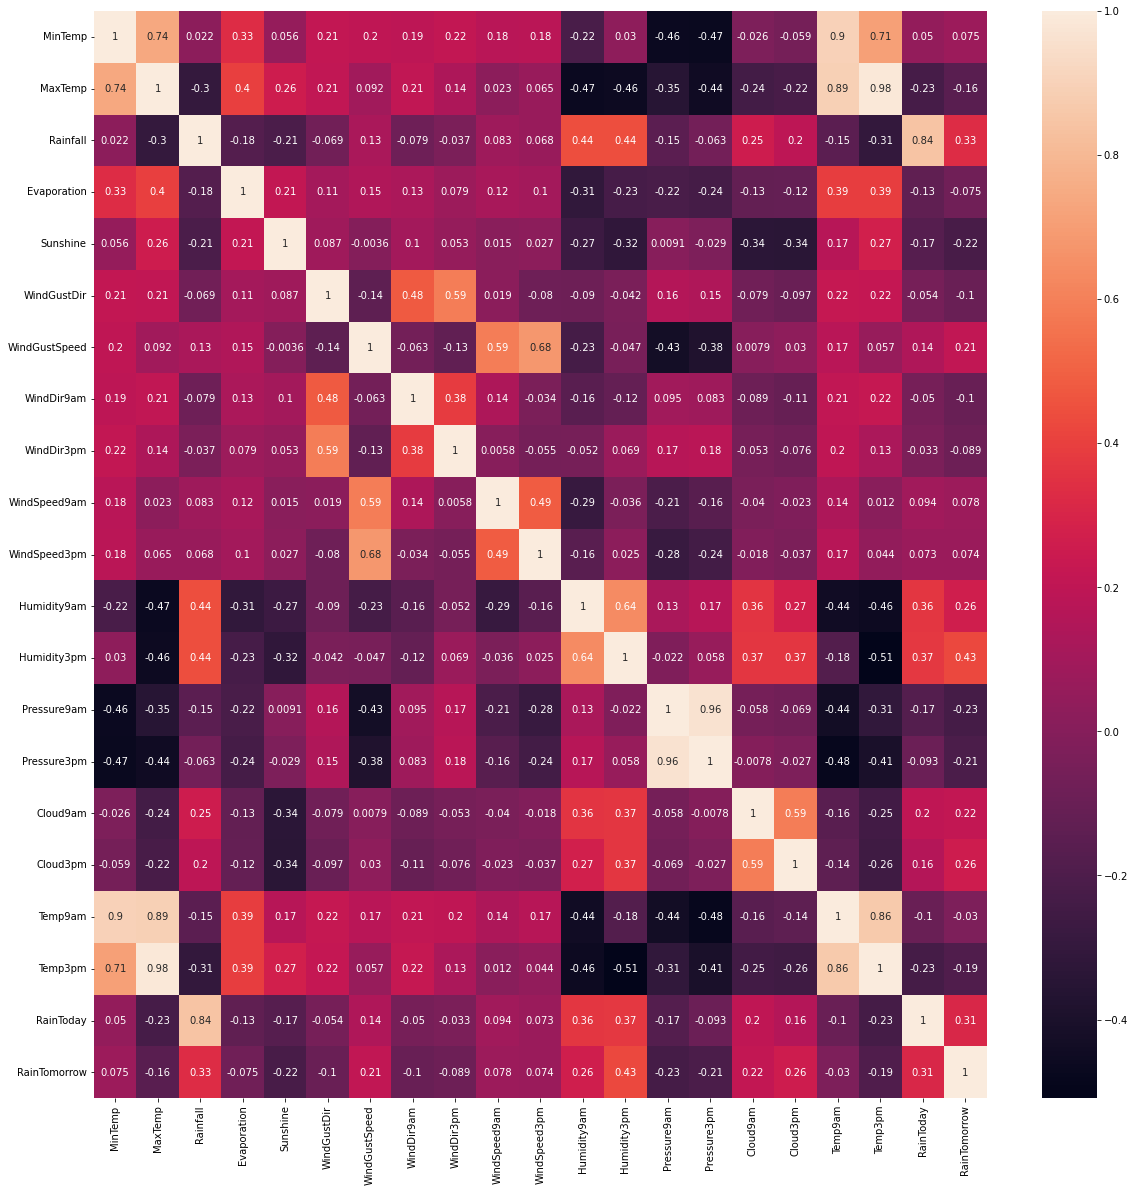

In [111]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


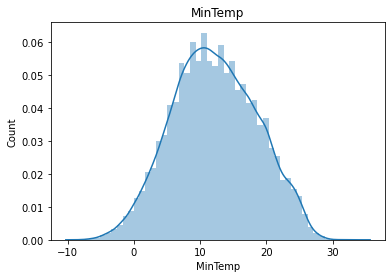

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


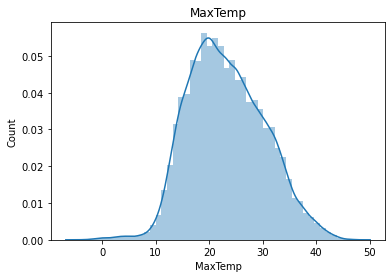

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


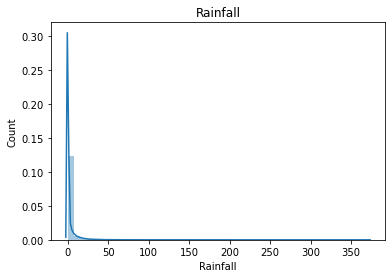

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


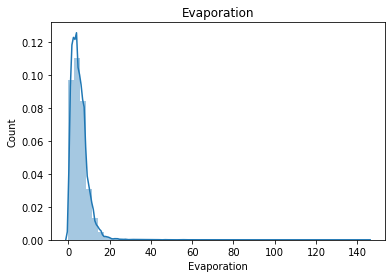

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


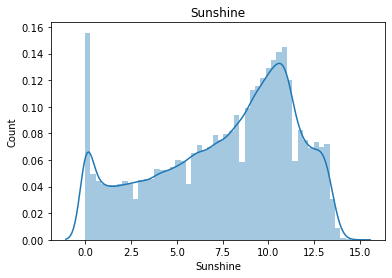

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


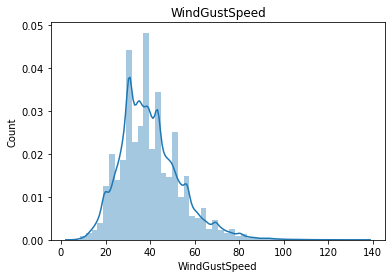

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


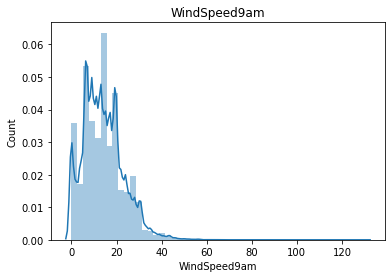

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


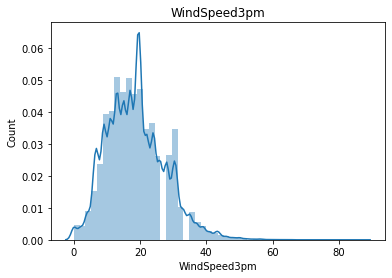

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


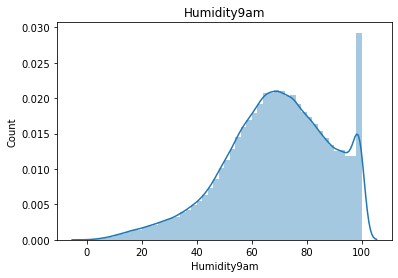

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


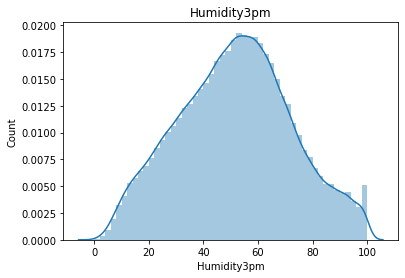

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


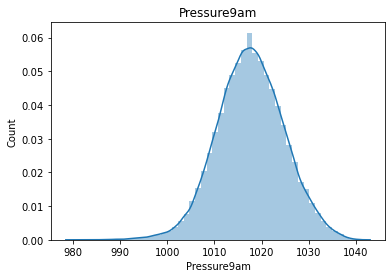

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


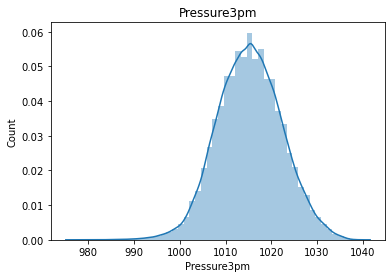

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


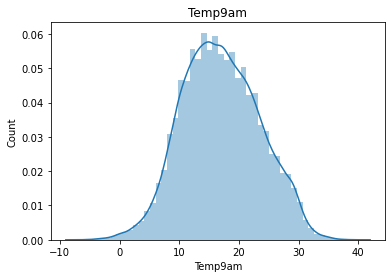

<Figure size 1080x1080 with 0 Axes>

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


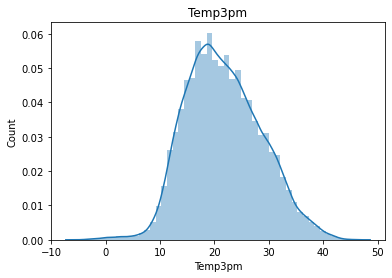

<Figure size 1080x1080 with 0 Axes>

In [113]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning

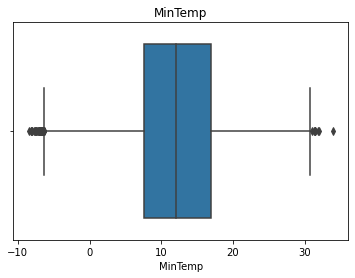

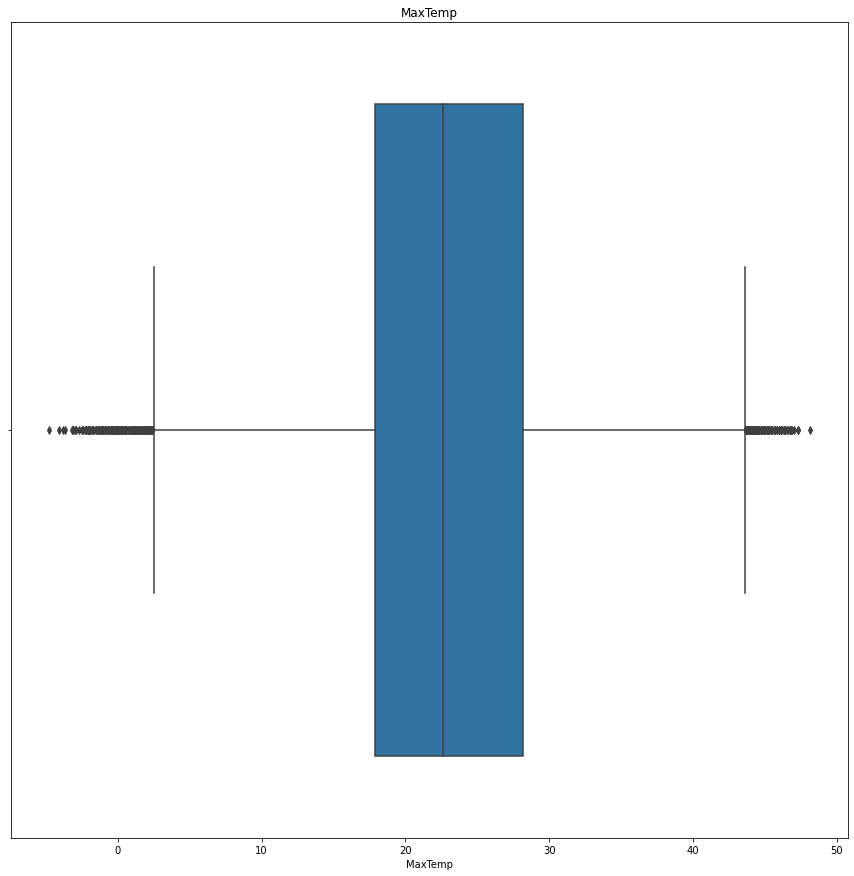

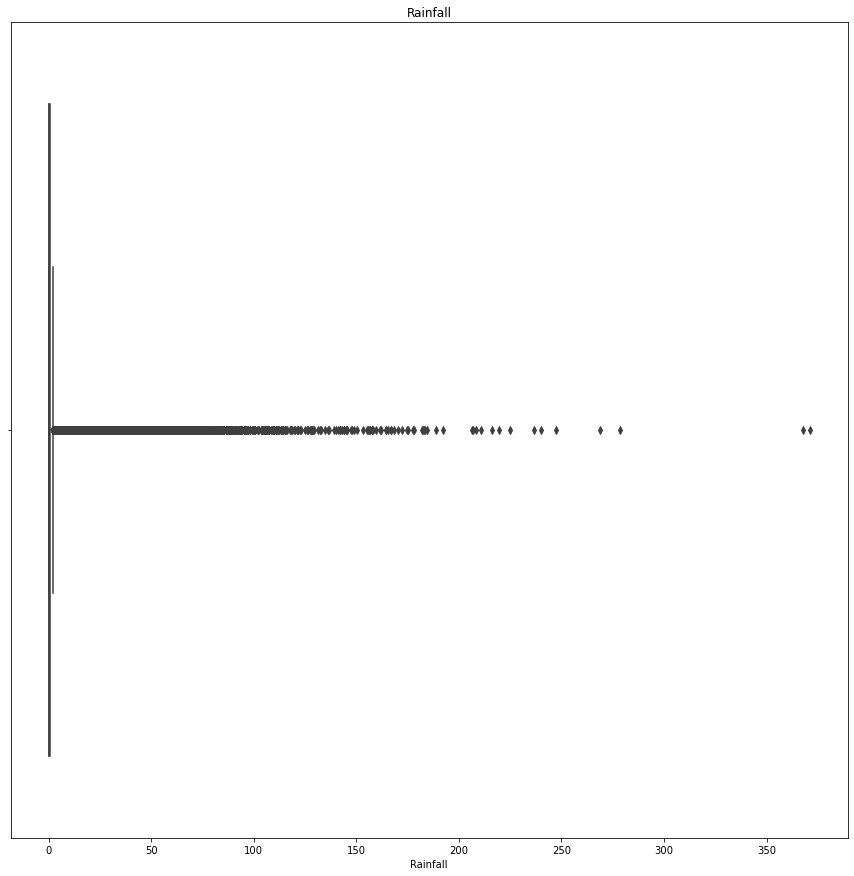

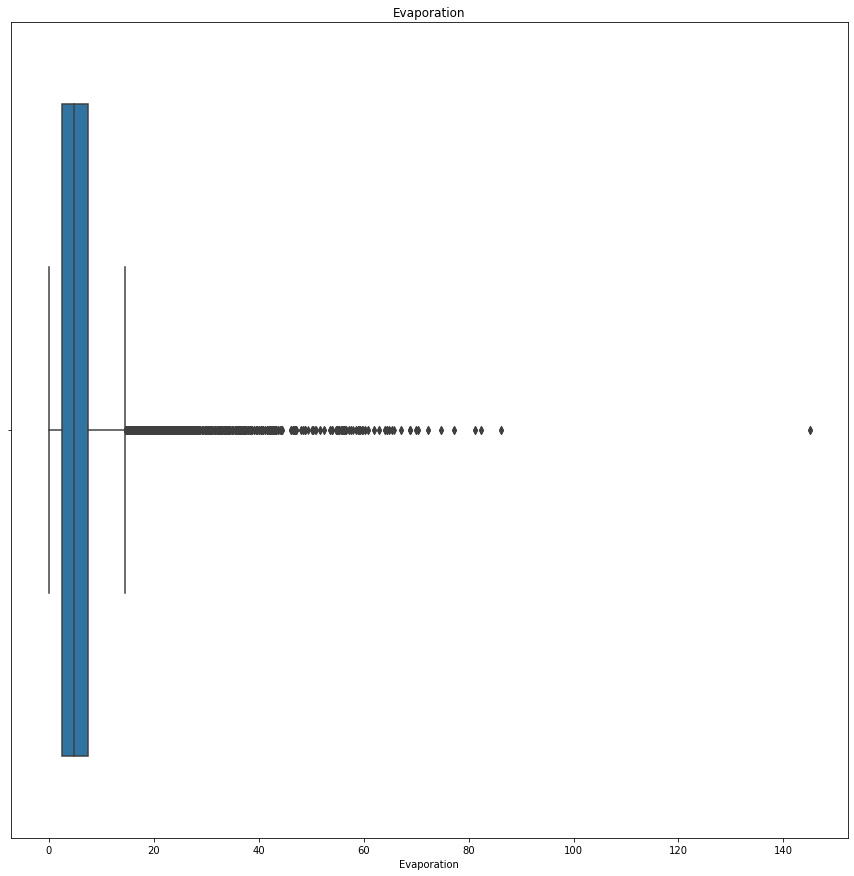

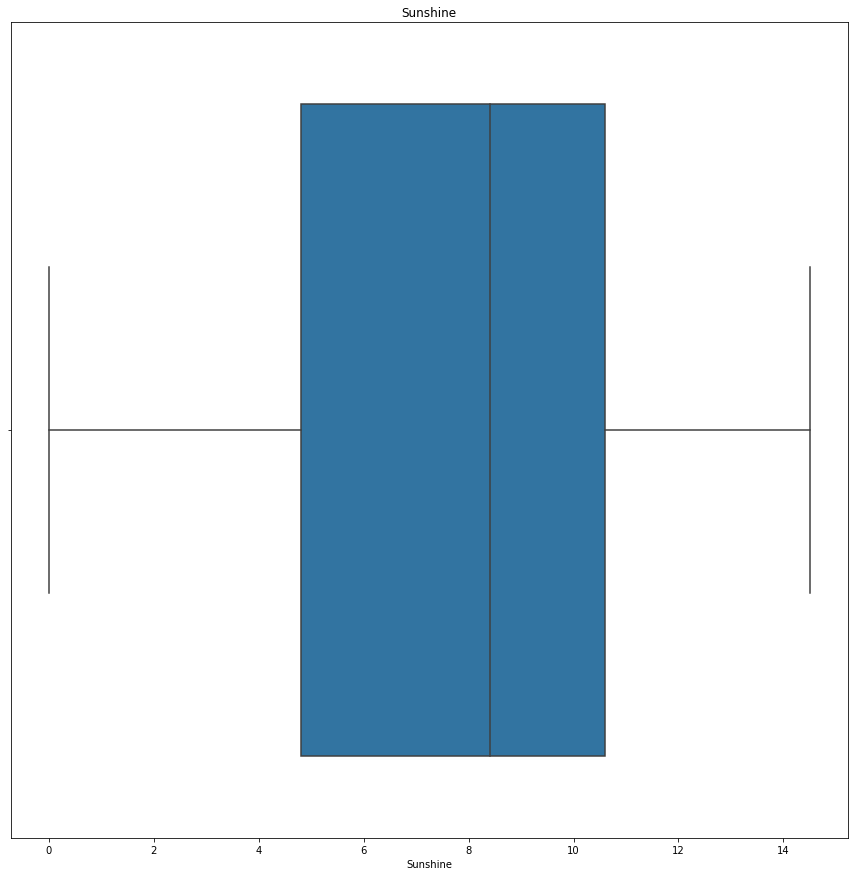

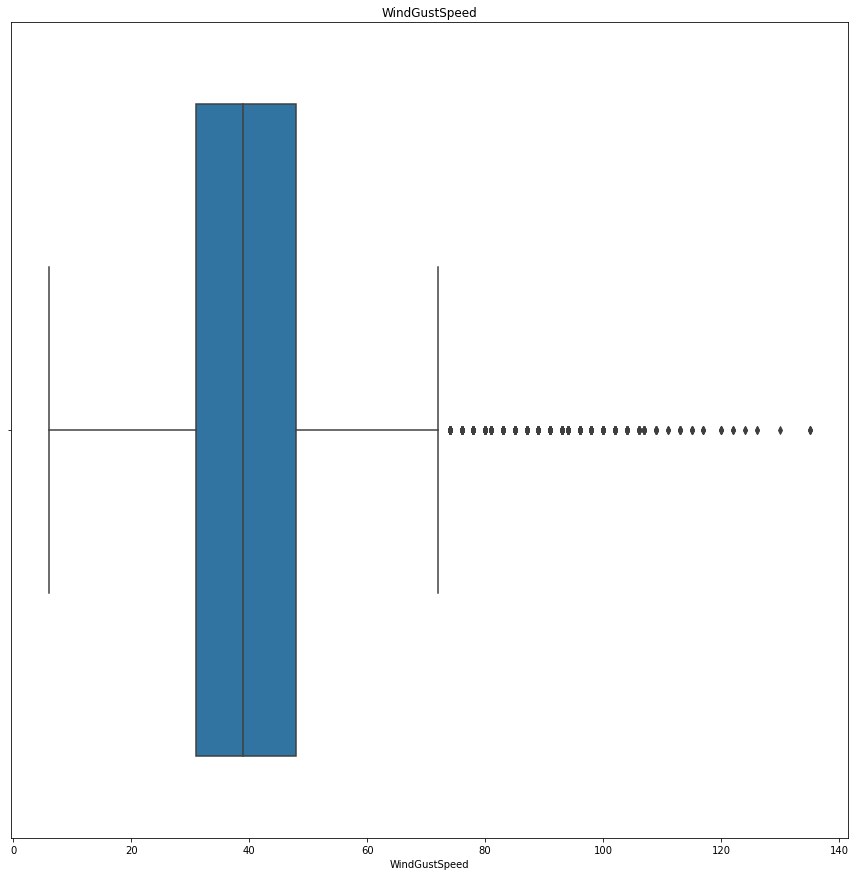

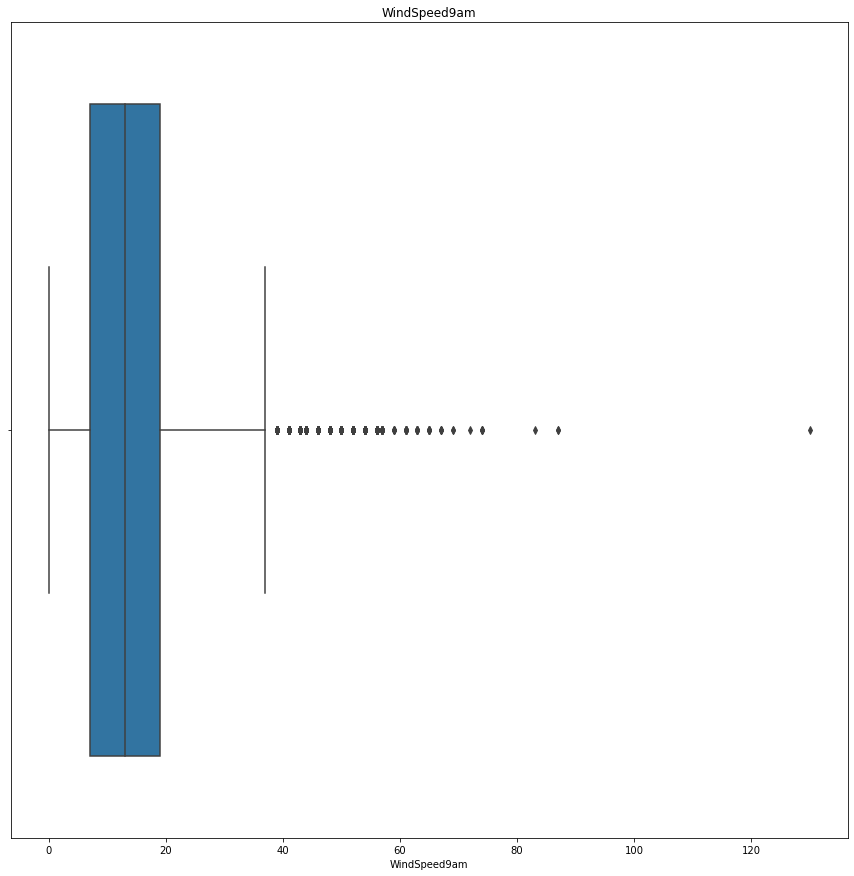

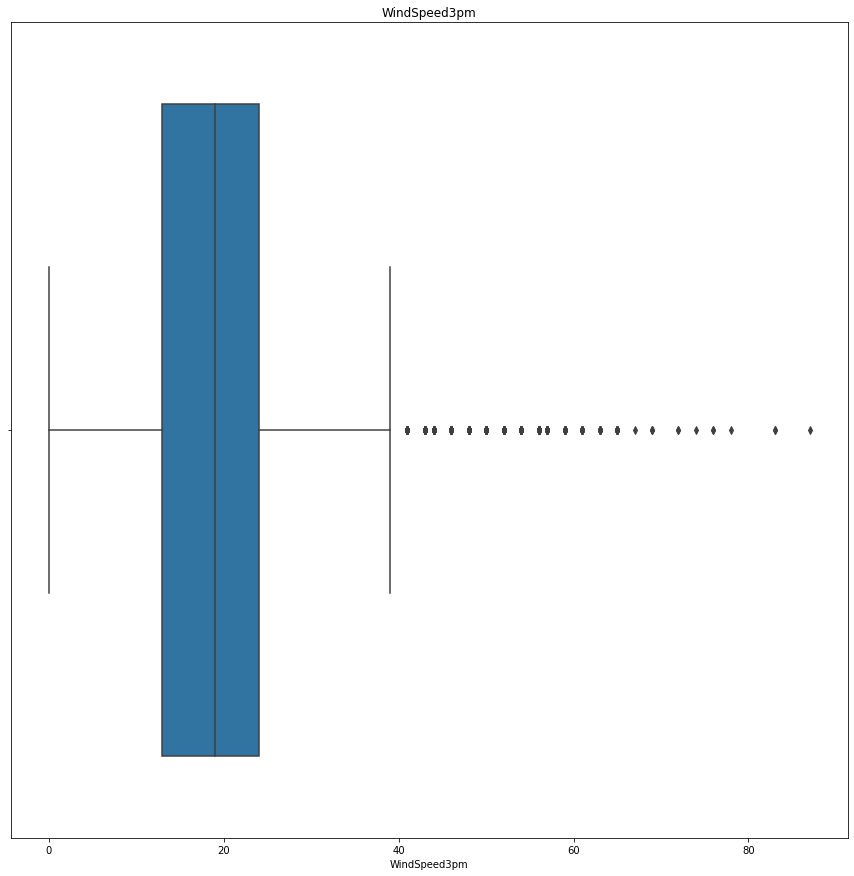

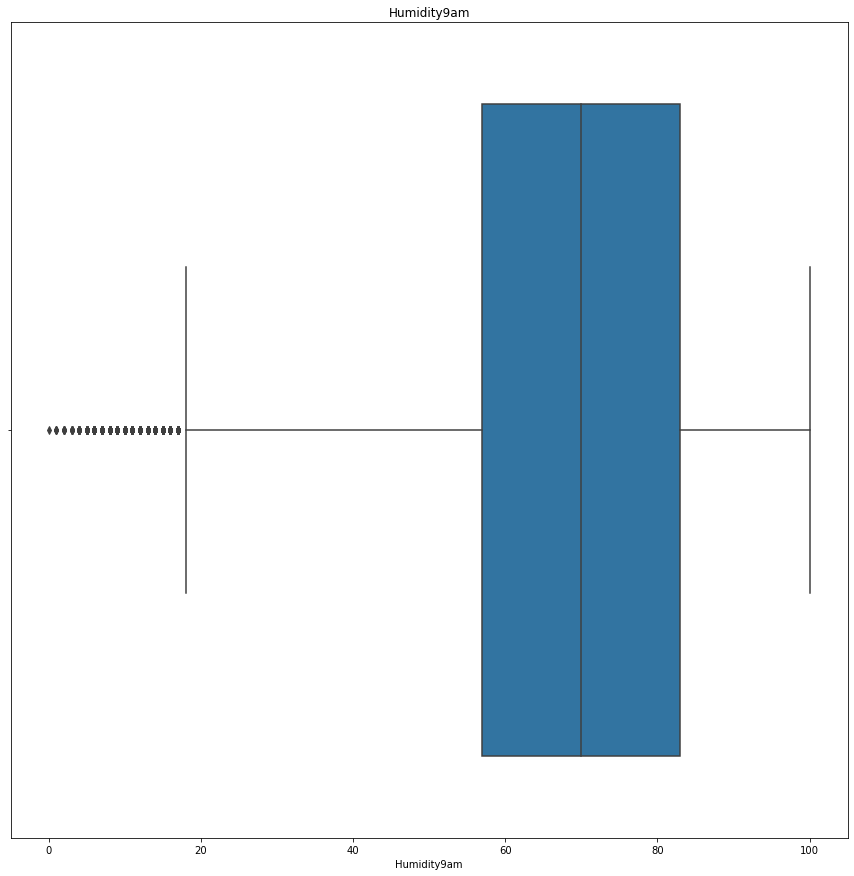

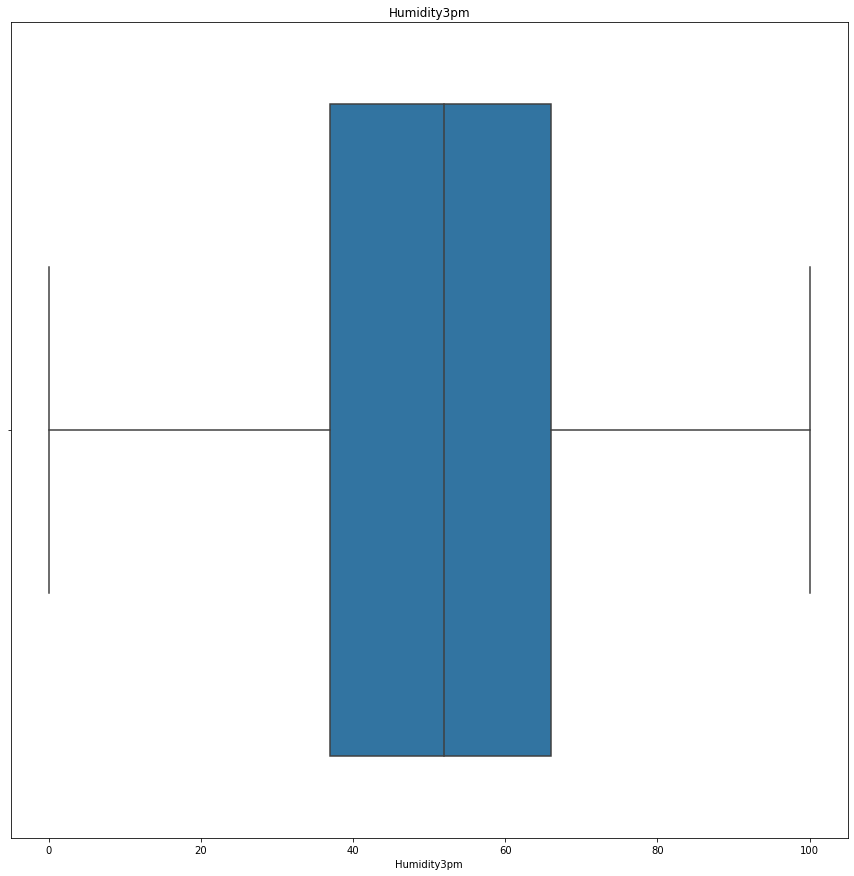

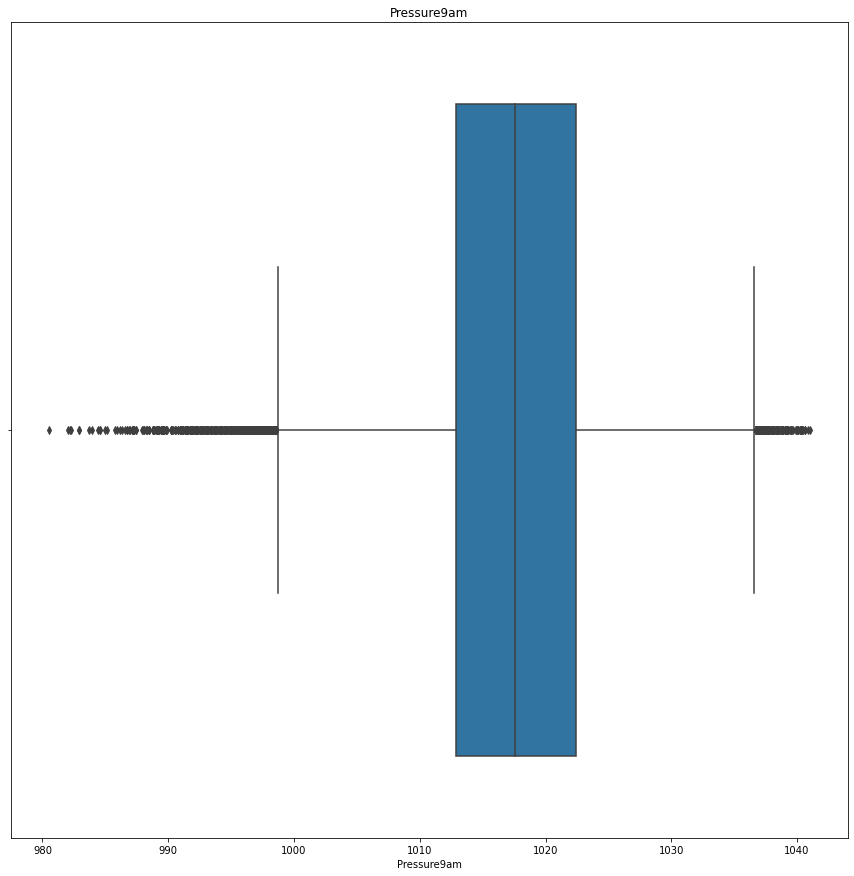

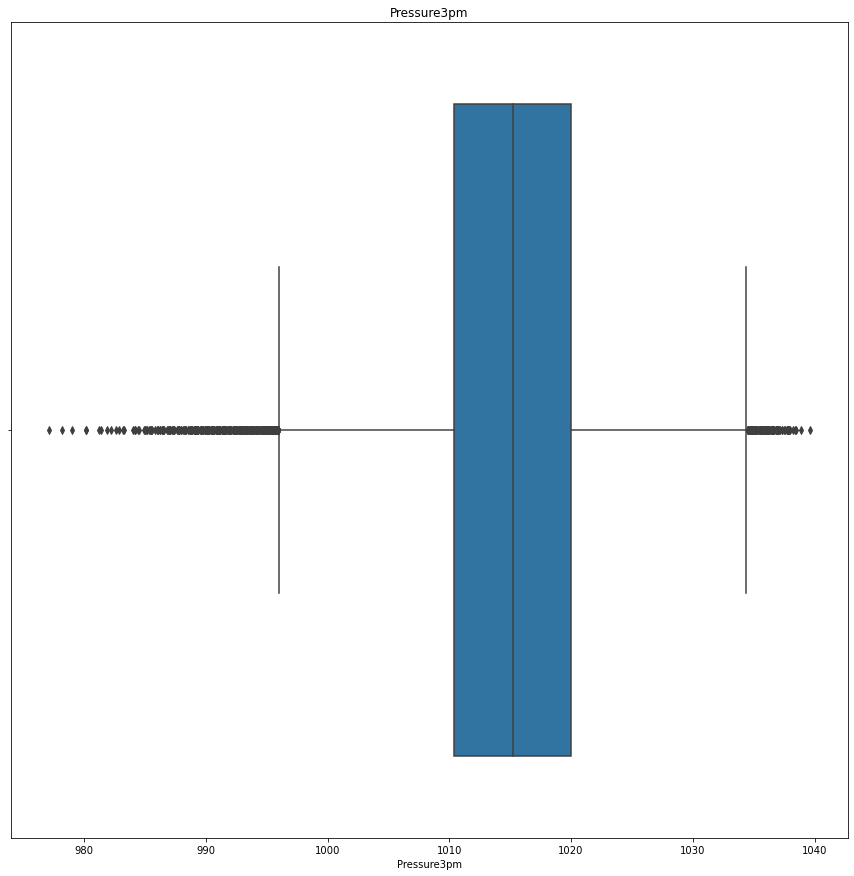

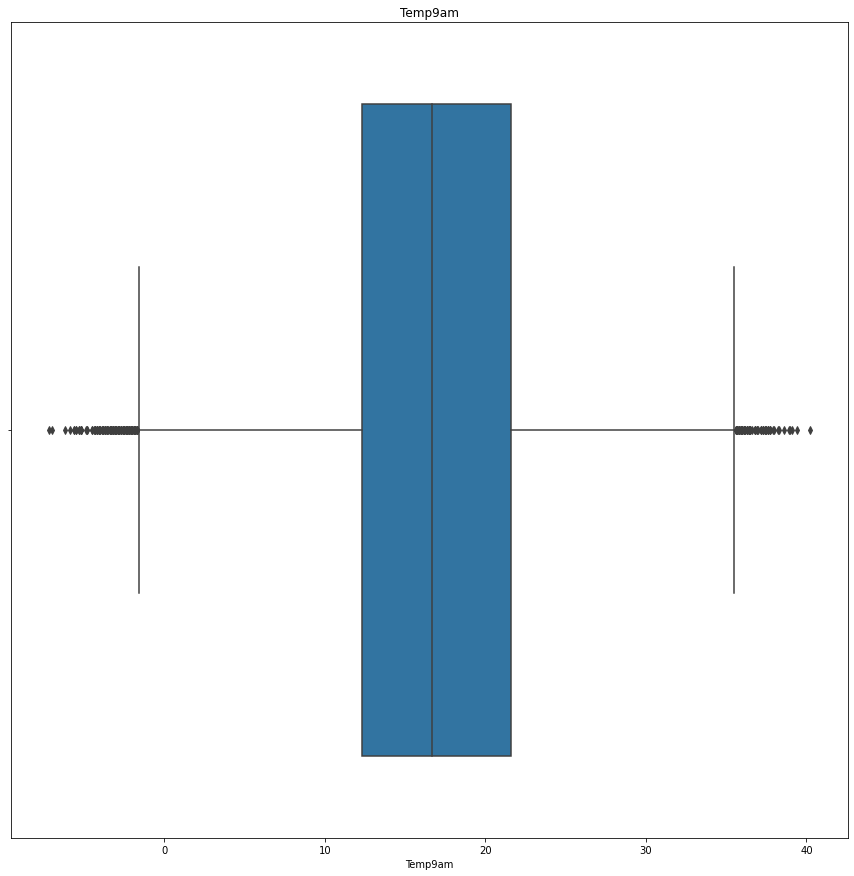

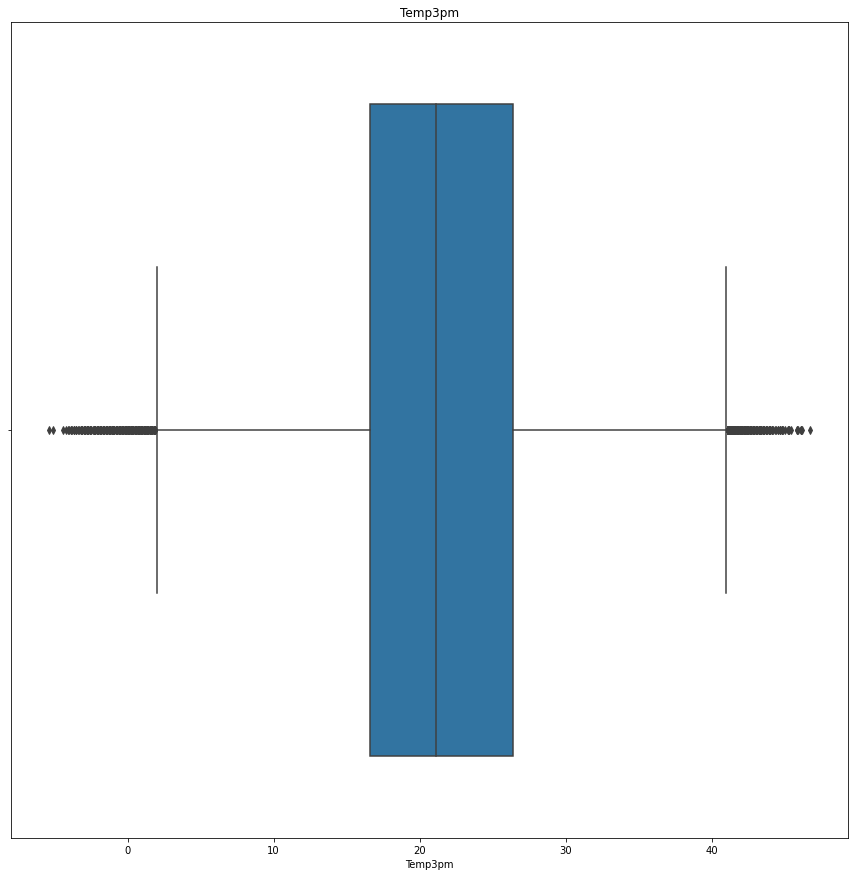

<Figure size 1080x1080 with 0 Axes>

In [115]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [117]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [119]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [121]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [123]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [125]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,7.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,7.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,7.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


In [127]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date DatetimeIndex(['2007-11-01', '2007-12-15', '2008-02-03', '2008-01-31',
               '2008-01-30', '2008-01-19', '2008-01-18', '2008-01-16',
               '2008-01-12', '2007-11-30',
               ...
               '2008-05-08', '2008-05-09', '2008-01-03', '2008-01-02',
               '2008-05-10', '2008-05-11', '2008-05-12', '2008-05-13',
               '2008-05-14', '2007-12-25'],
              dtype='datetime64[ns]', name='Date', length=3436, freq=None)
Location Int64Index([ 1,  3,  2,  4,  6,  5,  7,  8,  9, 12, 13, 11, 10, 16, 14, 15, 18,
            19, 17, 20, 22, 23, 21, 25, 24, 27, 30, 26, 28, 32, 31, 33, 35, 34,
            37, 36, 29, 38, 39, 45, 40, 41, 47, 42, 43, 44, 46, 49, 48],
           dtype='int64', name='Location')
WindGustDir Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0],
             dtype='float64', name='WindGustDir')
WindDir9am Float64Index([ 0.0,  2.0,  3.0,  4.0,  5.0,  1.

In [134]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [132]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [137]:
df.isnull().sum()*100/len(df)

Date               0.0
Location           0.0
MinTemp            0.0
MaxTemp            0.0
Rainfall           0.0
Evaporation        0.0
Sunshine           0.0
WindGustDir      100.0
WindGustSpeed      0.0
WindDir9am       100.0
WindDir3pm       100.0
WindSpeed9am       0.0
WindSpeed3pm       0.0
Humidity9am        0.0
Humidity3pm        0.0
Pressure9am        0.0
Pressure3pm        0.0
Cloud9am           0.0
Cloud3pm           0.0
Temp9am            0.0
Temp3pm            0.0
RainToday          0.0
RainTomorrow       0.0
Date_month         0.0
Date_day           0.0
dtype: float64

In [138]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [139]:
df1

RainTomorrow,0,1
Location,,
1,1914,1095
2,2090,950
3,2057,949
4,2087,922
5,2120,920
6,2090,919
7,2138,902
8,2130,879
9,2140,869


In [140]:
df1[1].sort_values(ascending = False)

Location
1     1095
2      950
3      949
4      922
5      920
6      919
7      902
8      879
9      869
10     865
11     852
12     819
13     808
14     781
15     775
16     774
17     761
18     738
19     731
20     713
21     709
22     700
23     699
24     688
25     653
26     645
27     643
28     636
29     629
30     618
31     595
32     592
33     583
34     568
35     567
36     562
37     560
38     536
39     519
40     505
41     472
42     394
43     386
44     327
45     265
46     244
47     242
48     202
49     116
Name: 1, dtype: int64

In [141]:
df1[1].sort_values(ascending = False).index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
           dtype='int64', name='Location')

In [142]:
len(df1[1].sort_values(ascending = False).index)

49

In [143]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [144]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [145]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [146]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,NaN,13.4,22.9,0.6,2.4,8.3,NaN,44.0,NaN,NaN,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,NaN,7.4,25.1,0.0,3.6,10.0,NaN,44.0,NaN,NaN,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,NaN,12.9,25.7,0.0,2.6,4.4,NaN,46.0,NaN,NaN,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,NaN,9.2,28.0,0.0,18.4,8.9,NaN,24.0,NaN,NaN,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,NaN,17.5,32.3,1.0,5.4,3.0,NaN,41.0,NaN,NaN,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,NaN,2.8,23.4,0.0,1.4,7.8,NaN,31.0,NaN,NaN,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,7.0,10.1,22.4,0,0,6,21
145456,2017-06-22,NaN,3.6,25.3,0.0,7.6,13.5,NaN,22.0,NaN,NaN,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,7.0,10.9,24.5,0,0,6,22
145457,2017-06-23,NaN,5.4,26.9,0.0,6.8,11.0,NaN,37.0,NaN,NaN,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,7.0,12.5,26.1,0,0,6,23
145458,2017-06-24,NaN,7.8,27.0,0.0,2.6,13.2,NaN,28.0,NaN,NaN,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


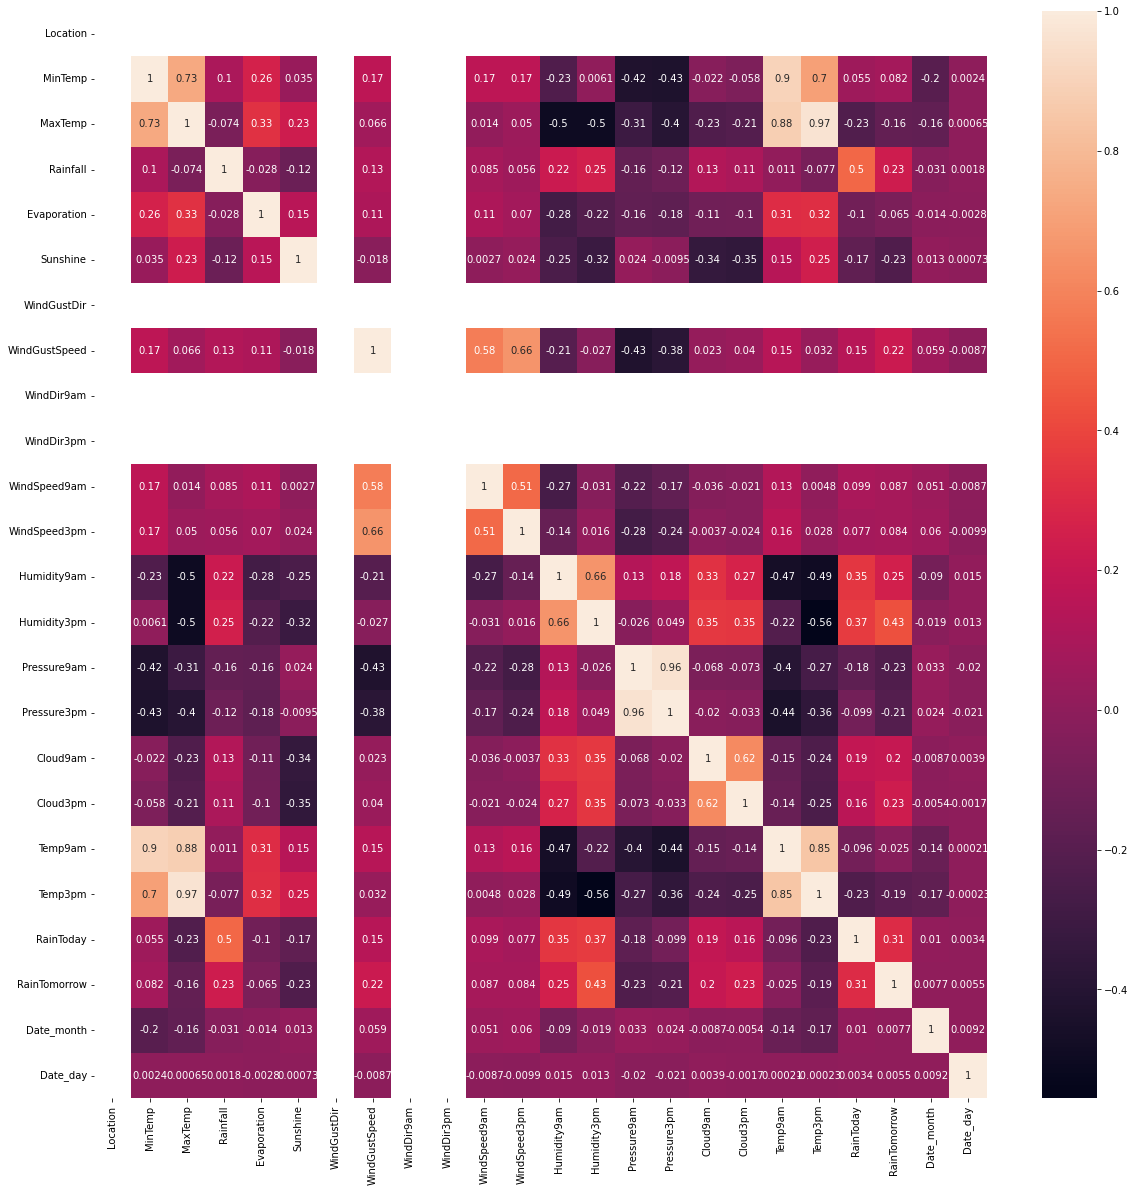

In [147]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

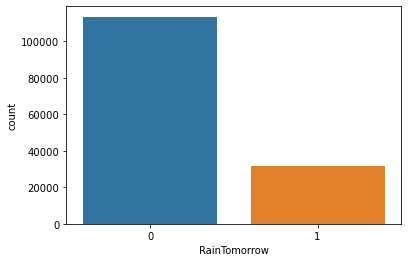

In [148]:
sns.countplot(df["RainTomorrow"])

In [149]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,NaN,13.4,22.9,0.6,2.4,8.3,NaN,44.0,NaN,NaN,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,NaN,7.4,25.1,0.0,3.6,10.0,NaN,44.0,NaN,NaN,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,NaN,12.9,25.7,0.0,2.6,4.4,NaN,46.0,NaN,NaN,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,NaN,9.2,28.0,0.0,18.4,8.9,NaN,24.0,NaN,NaN,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,NaN,17.5,32.3,1.0,5.4,3.0,NaN,41.0,NaN,NaN,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,NaN,2.8,23.4,0.0,1.4,7.8,NaN,31.0,NaN,NaN,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,7.0,10.1,22.4,0,0,6,21
145456,2017-06-22,NaN,3.6,25.3,0.0,7.6,13.5,NaN,22.0,NaN,NaN,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,7.0,10.9,24.5,0,0,6,22
145457,2017-06-23,NaN,5.4,26.9,0.0,6.8,11.0,NaN,37.0,NaN,NaN,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,7.0,12.5,26.1,0,0,6,23
145458,2017-06-24,NaN,7.8,27.0,0.0,2.6,13.2,NaN,28.0,NaN,NaN,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning

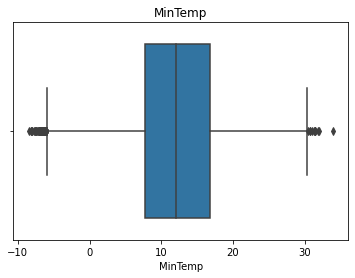

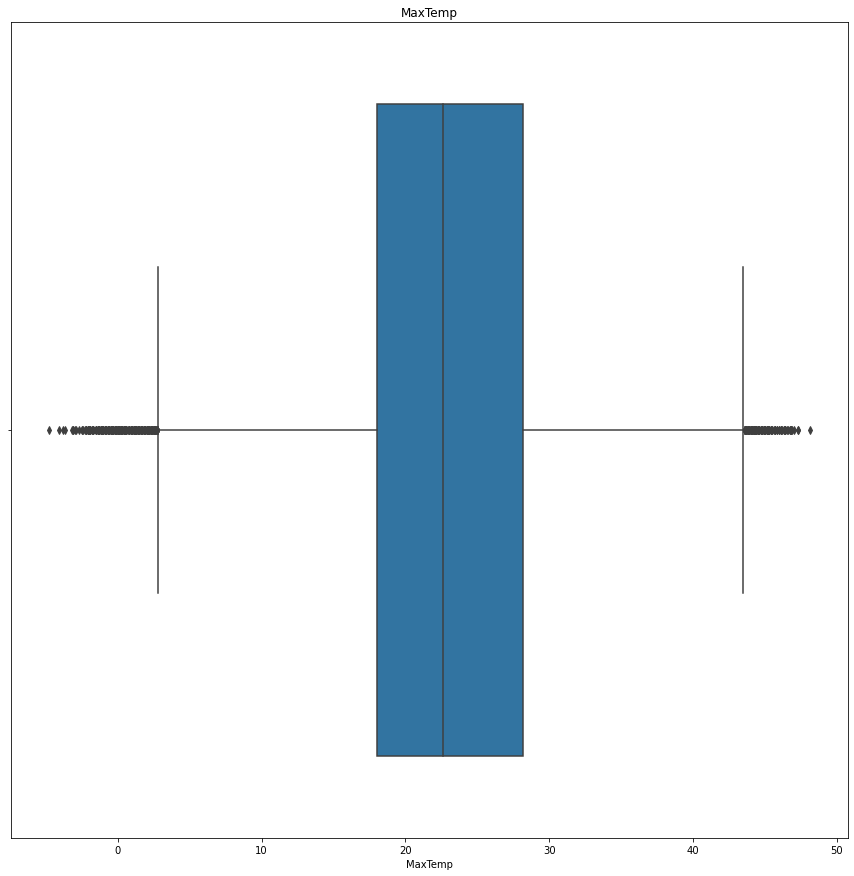

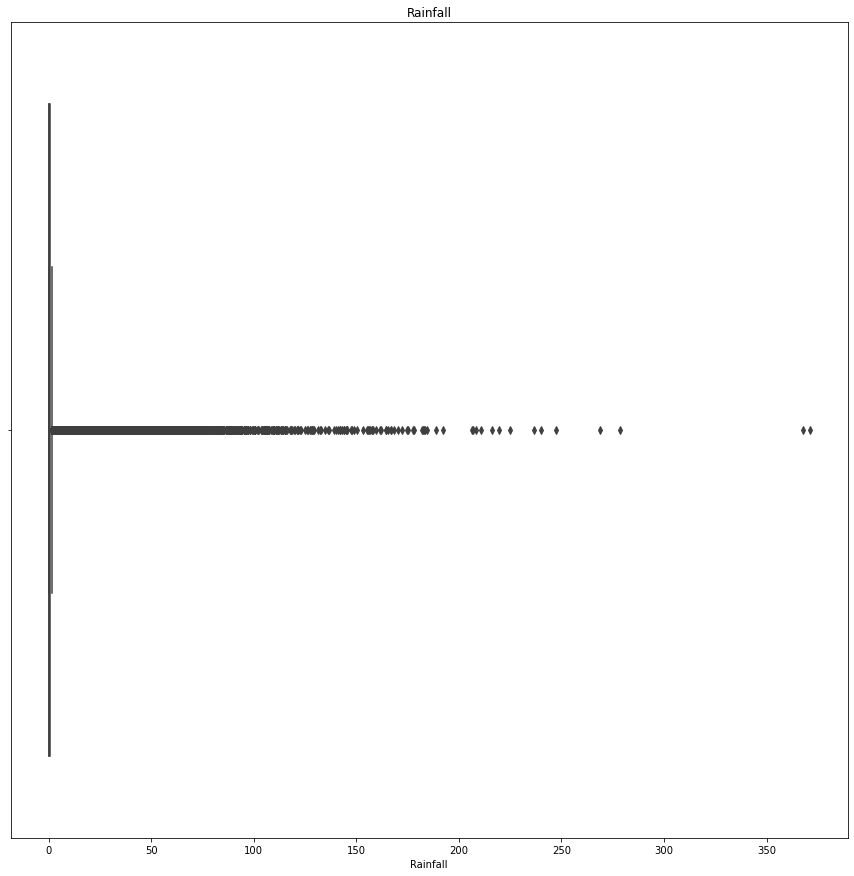

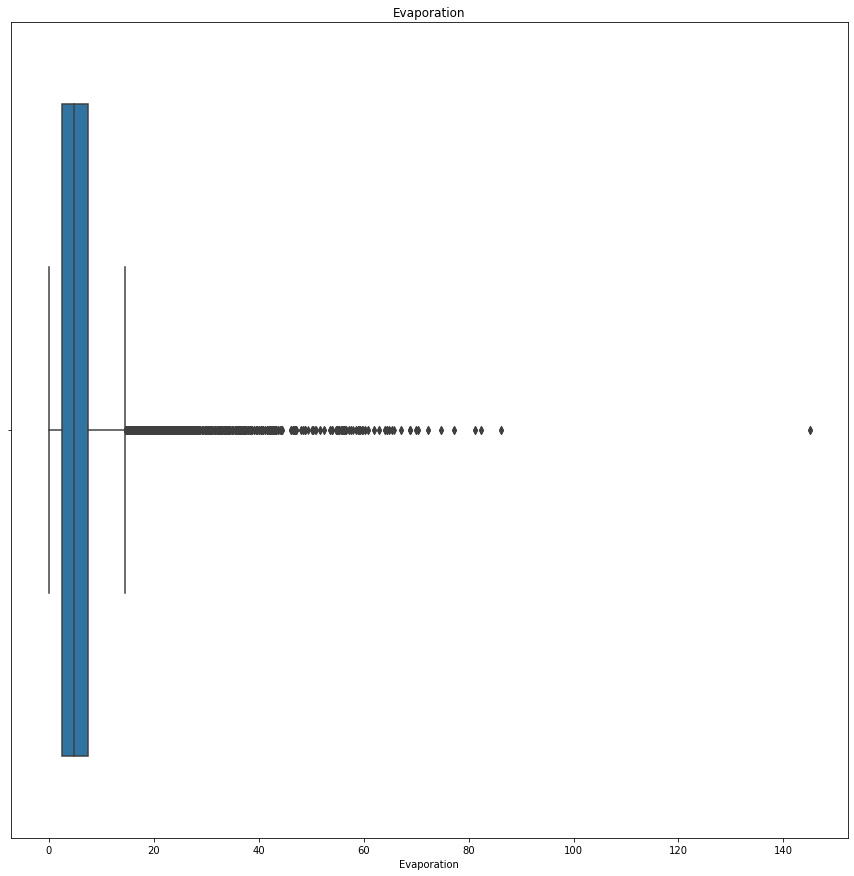

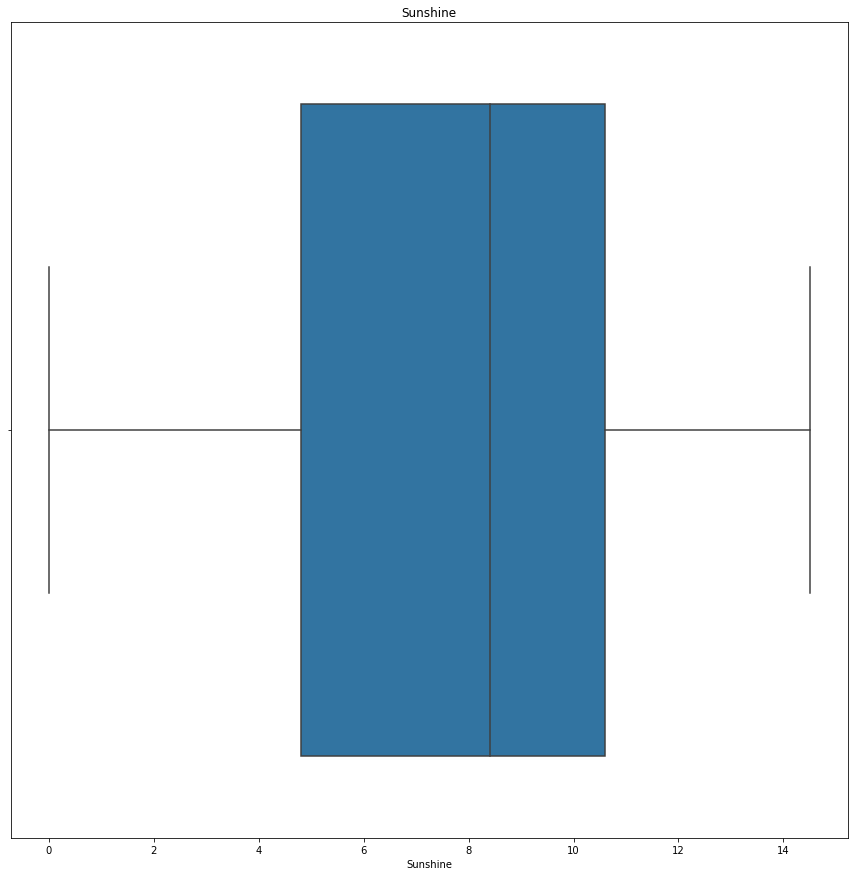

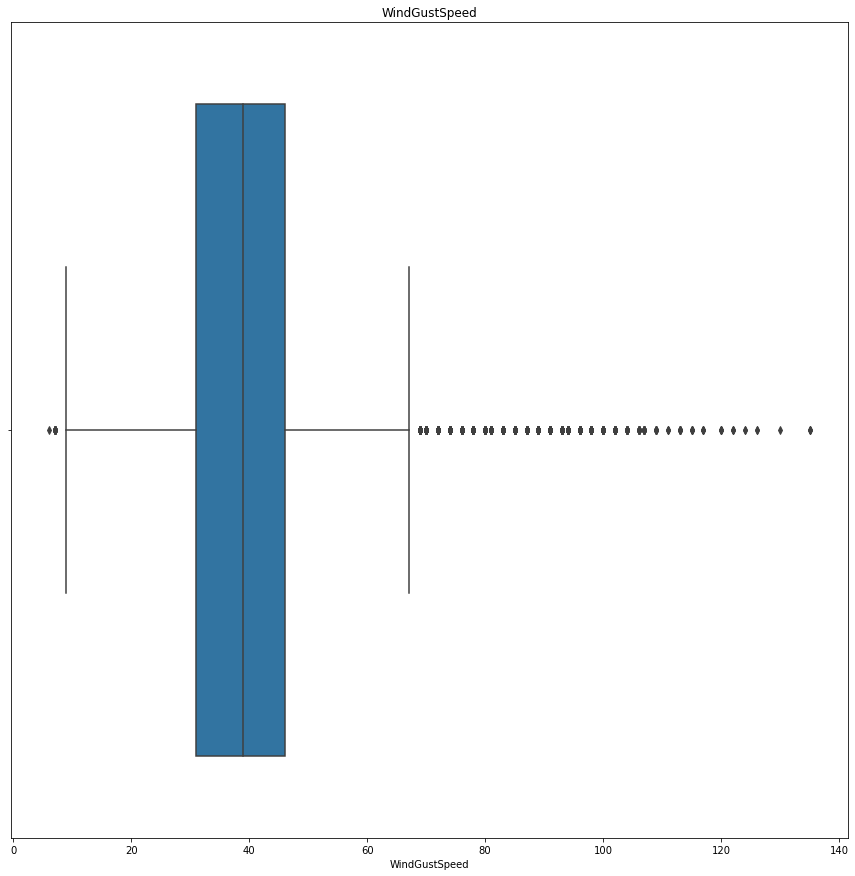

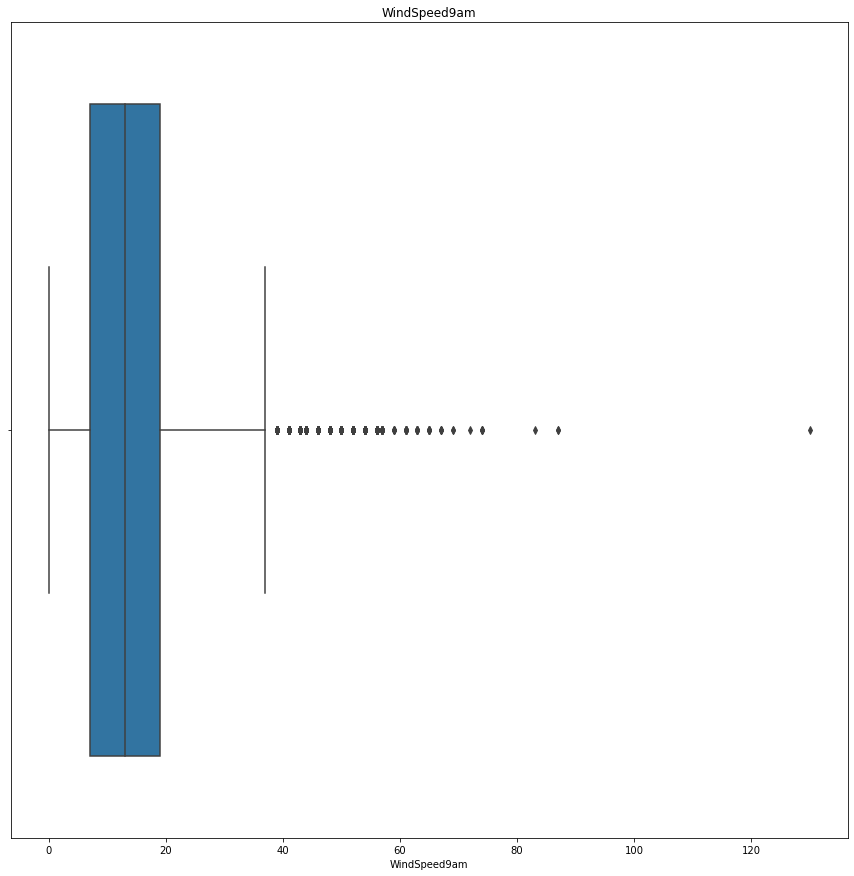

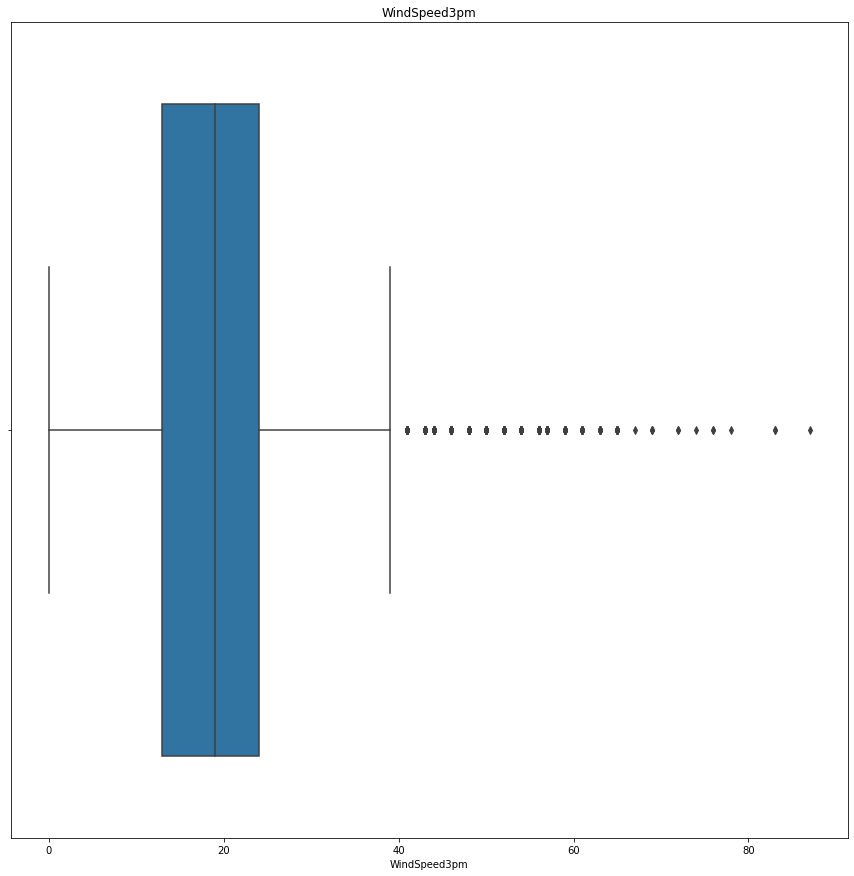

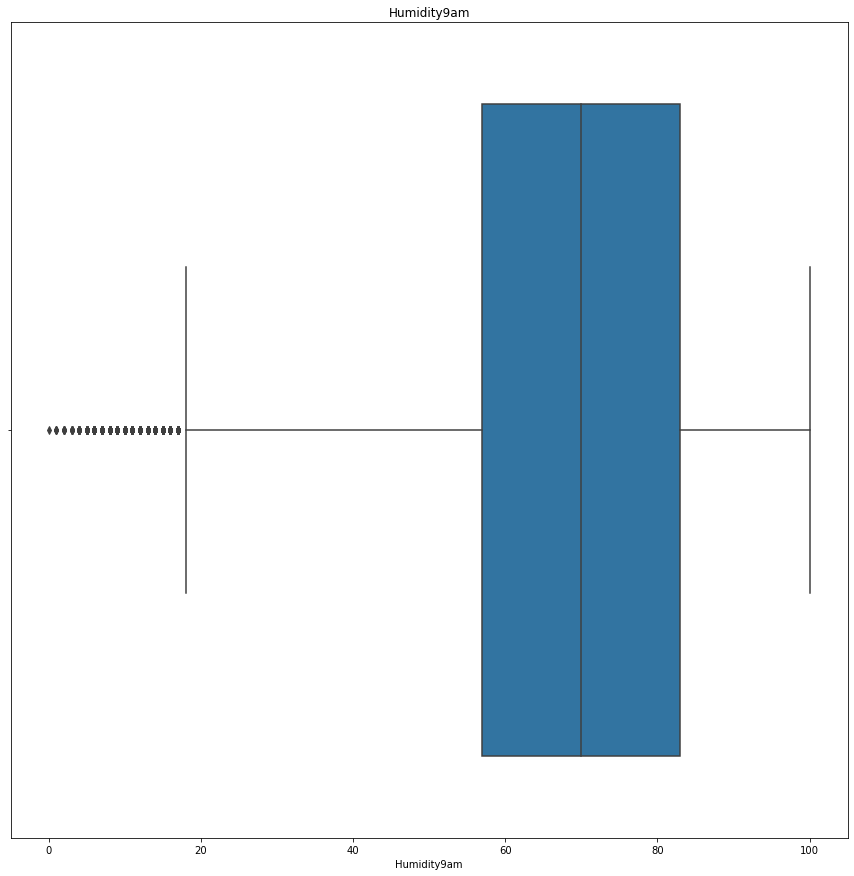

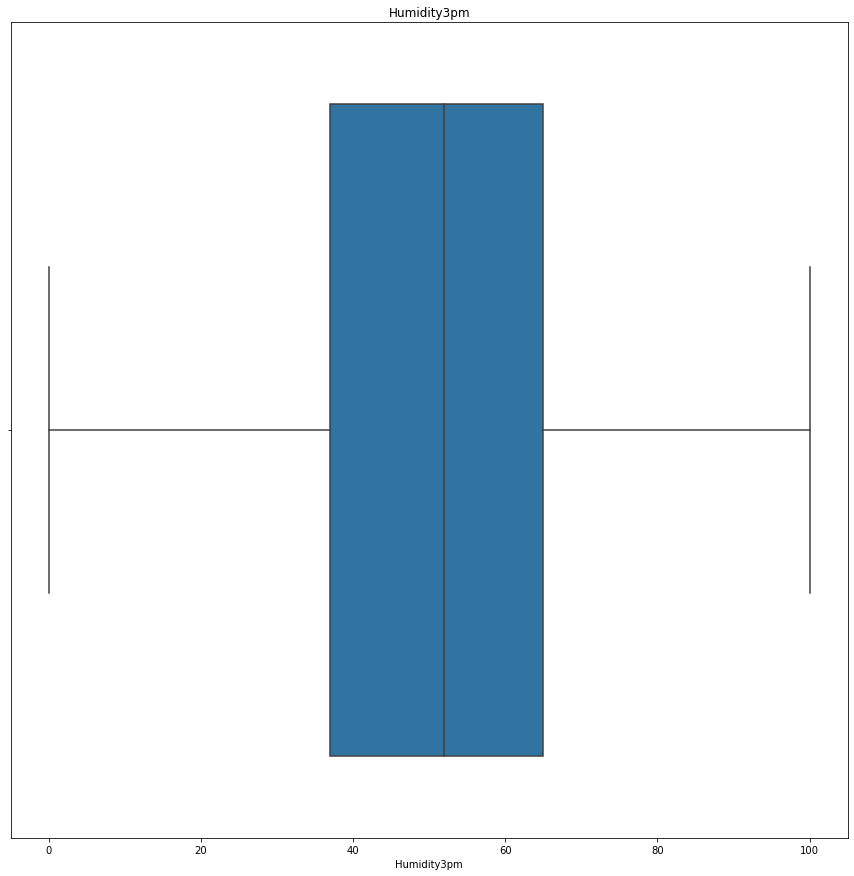

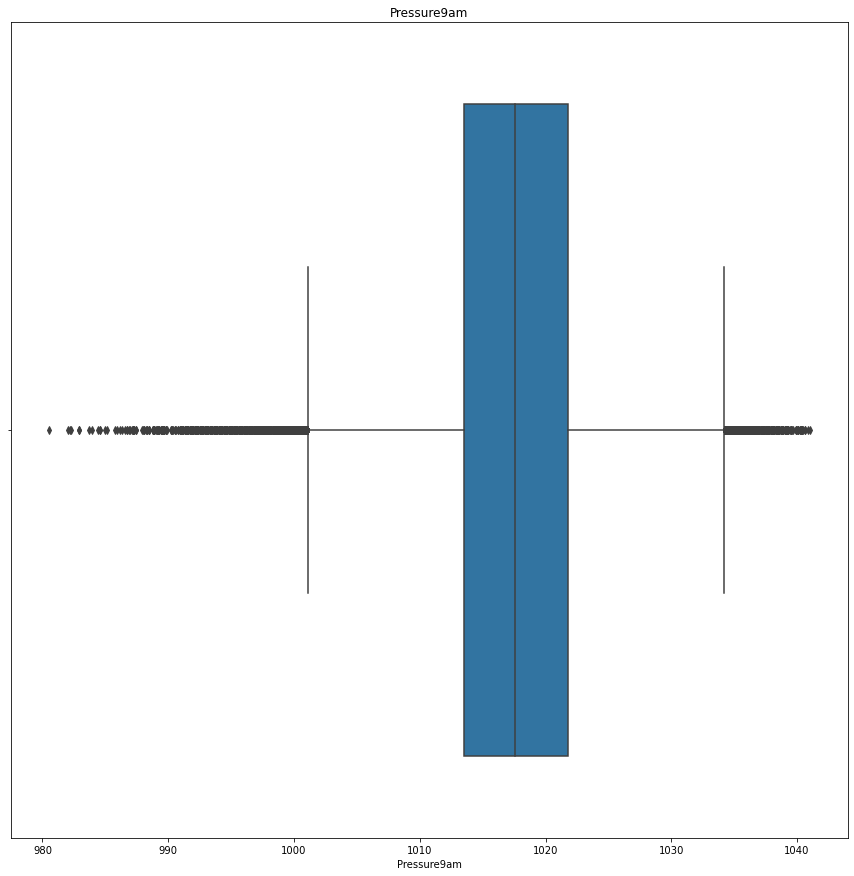

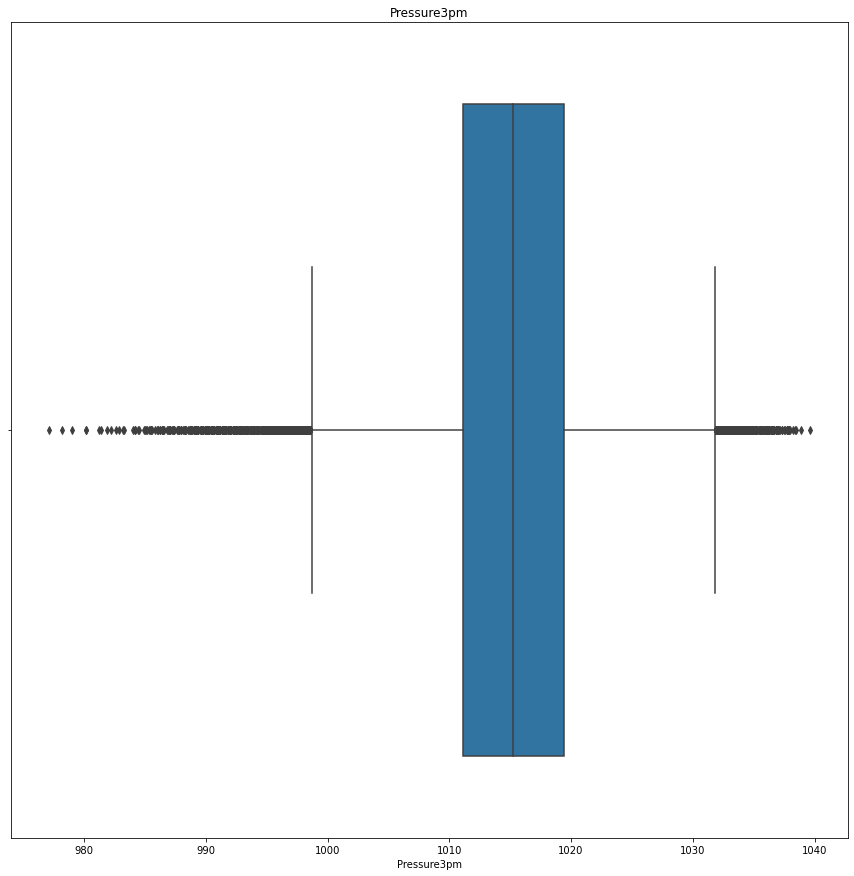

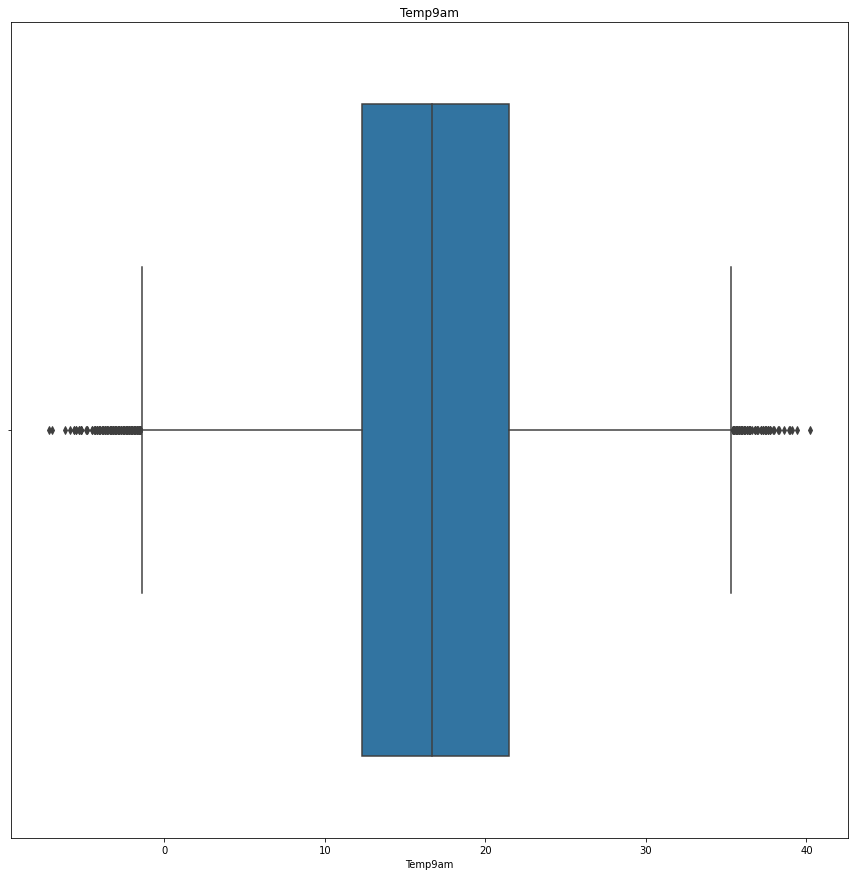

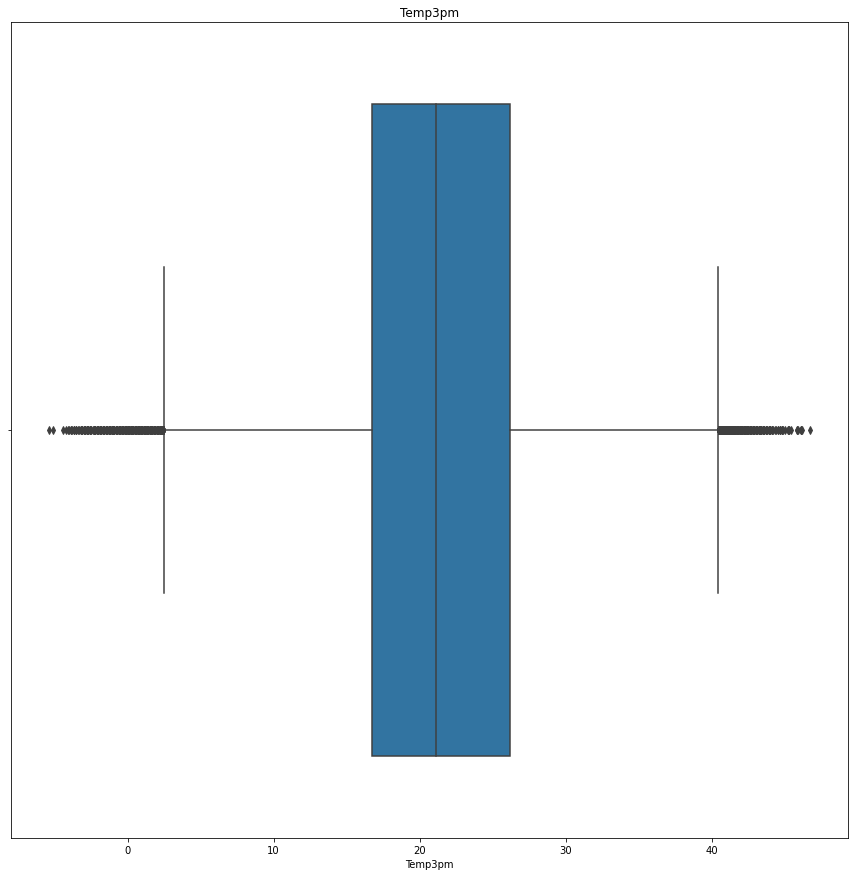

<Figure size 1080x1080 with 0 Axes>

In [150]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [151]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [152]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [153]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [154]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [155]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [156]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [157]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [158]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [159]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [160]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [161]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [162]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [163]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [164]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [165]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [166]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [167]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [168]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [169]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [170]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [171]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [172]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [173]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [174]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [175]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning

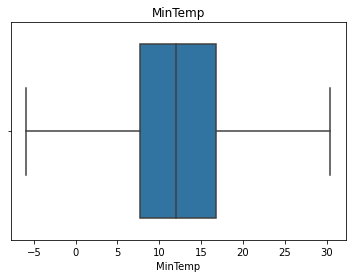

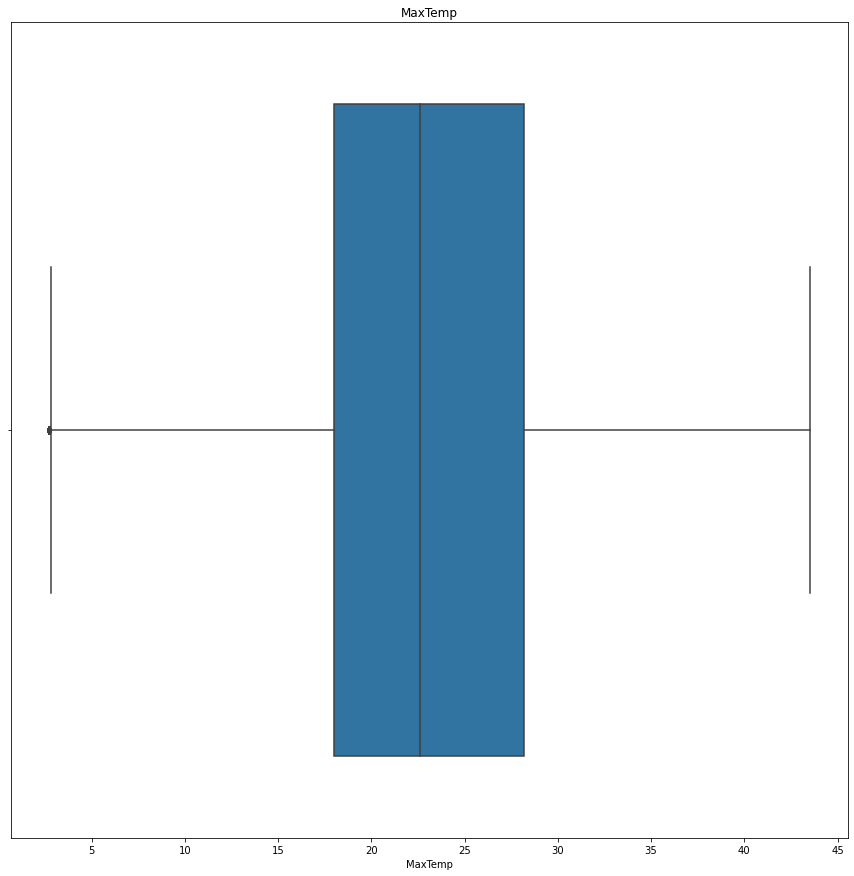

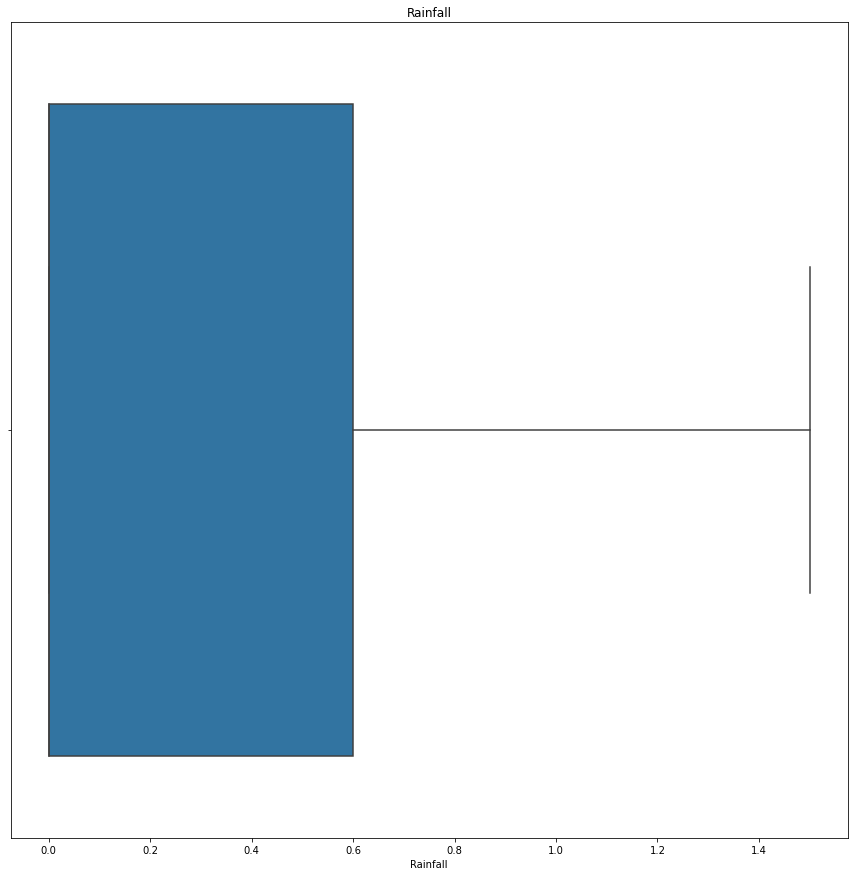

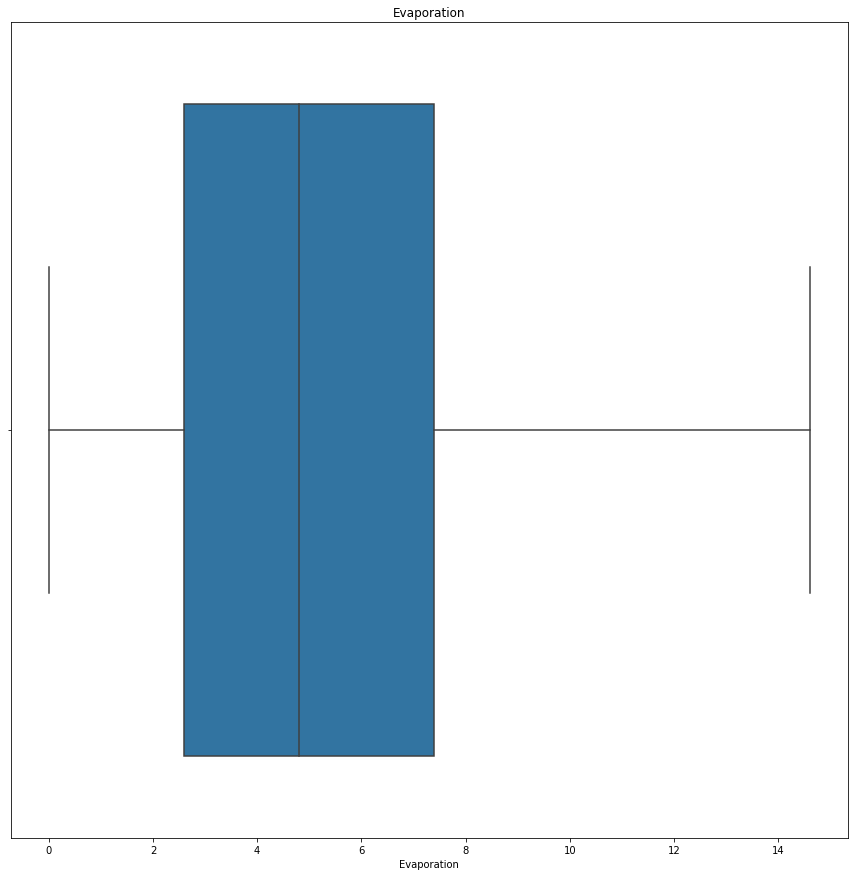

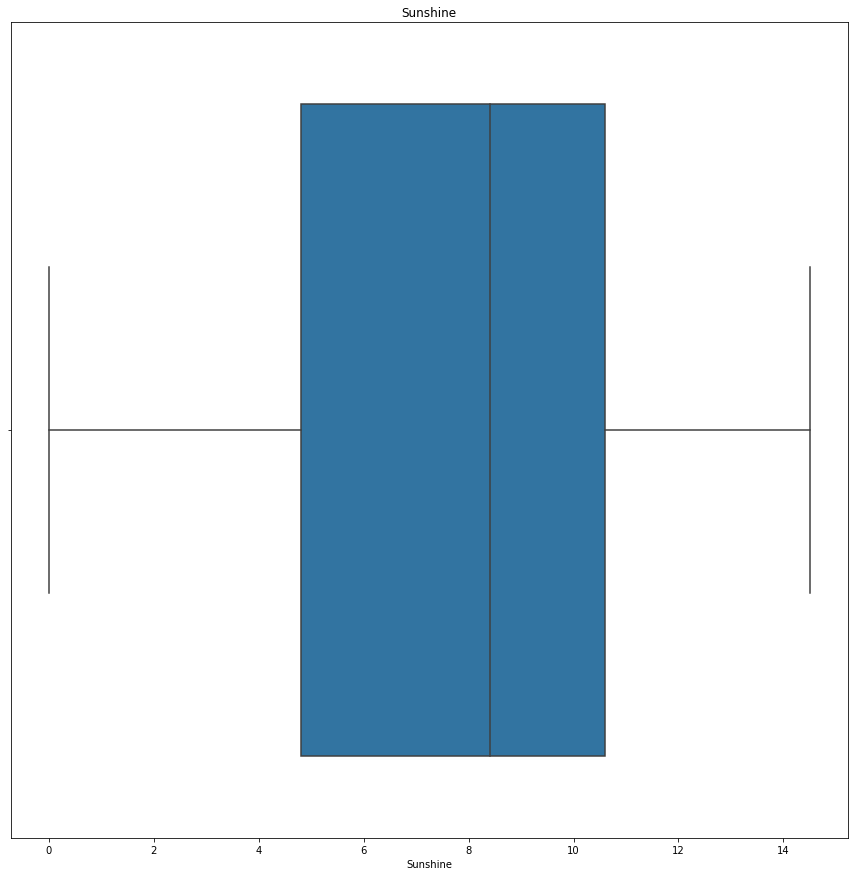

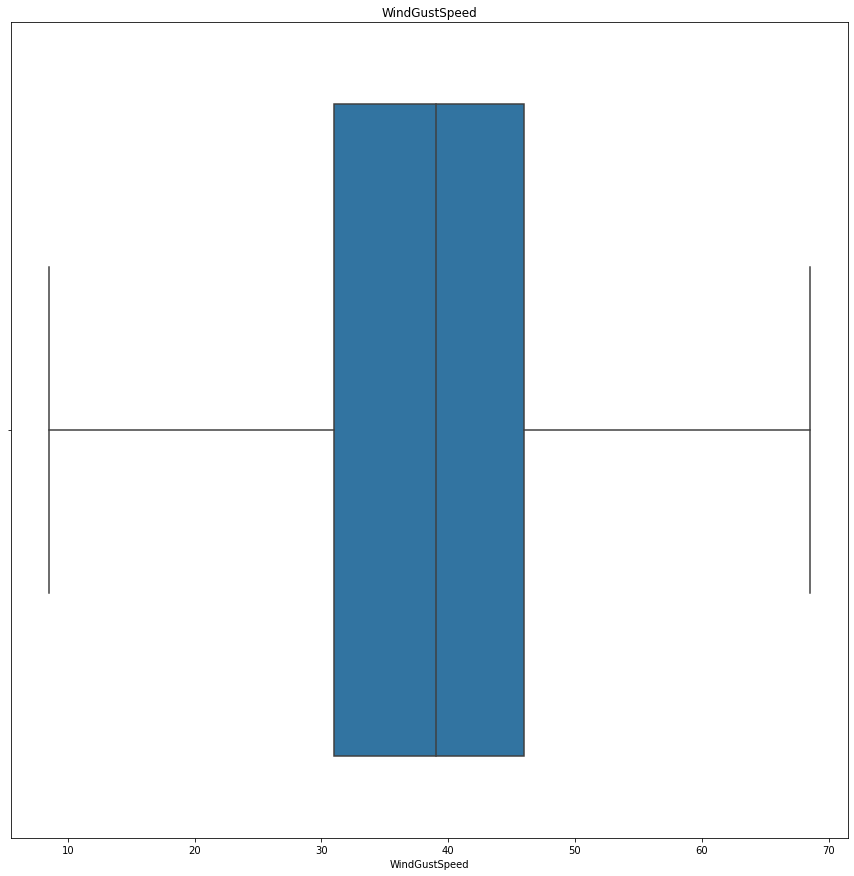

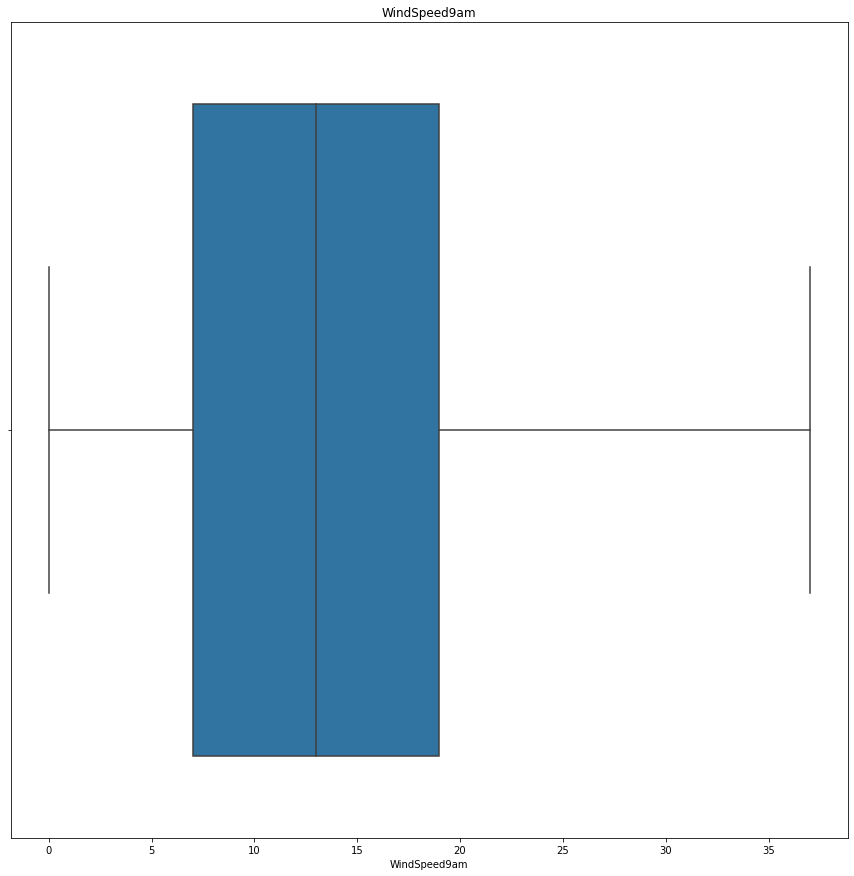

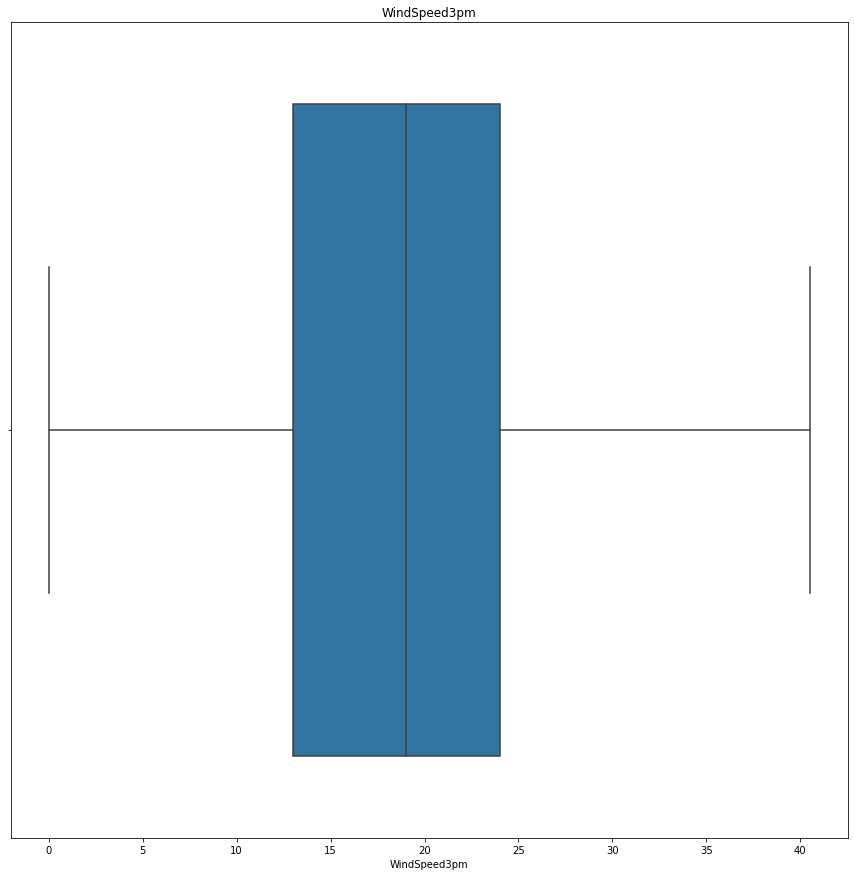

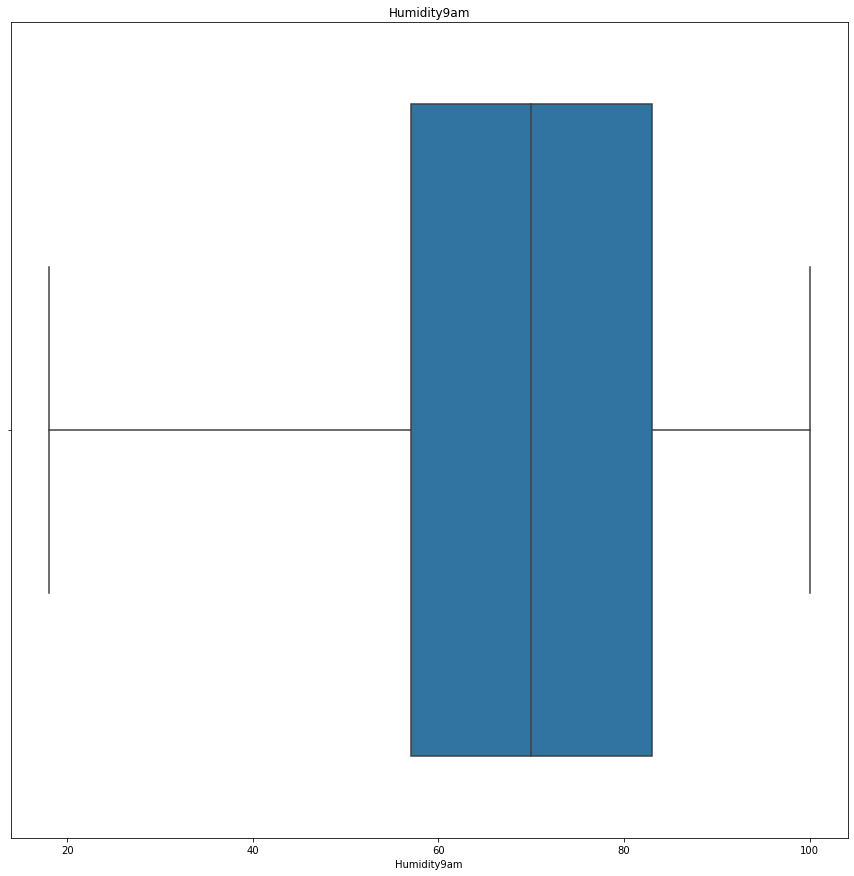

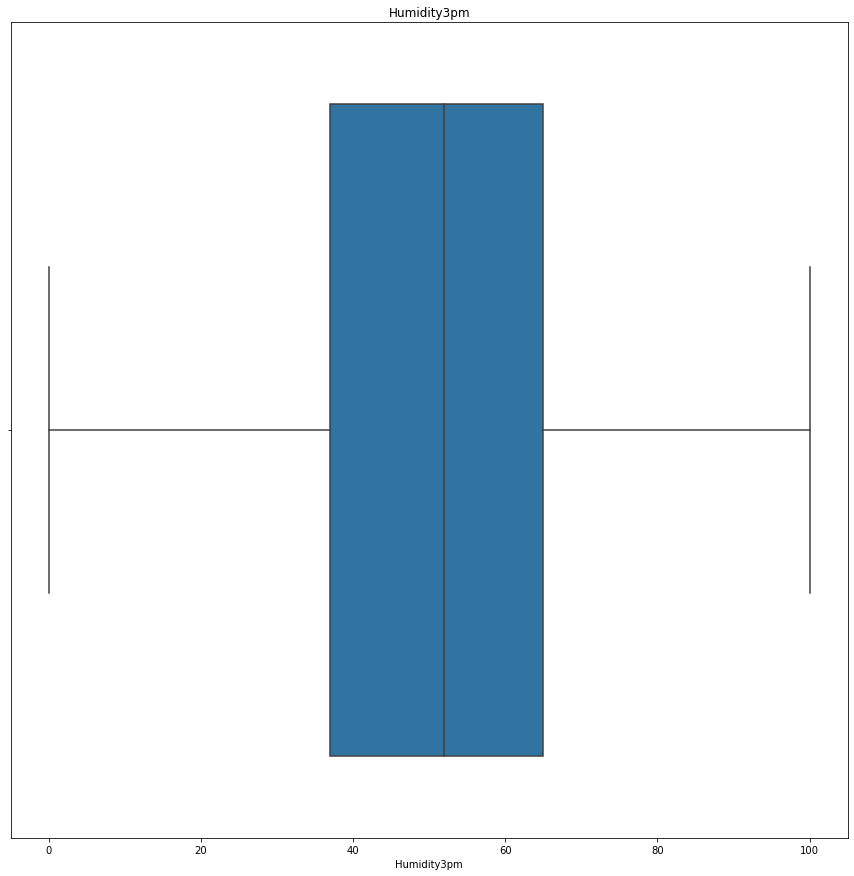

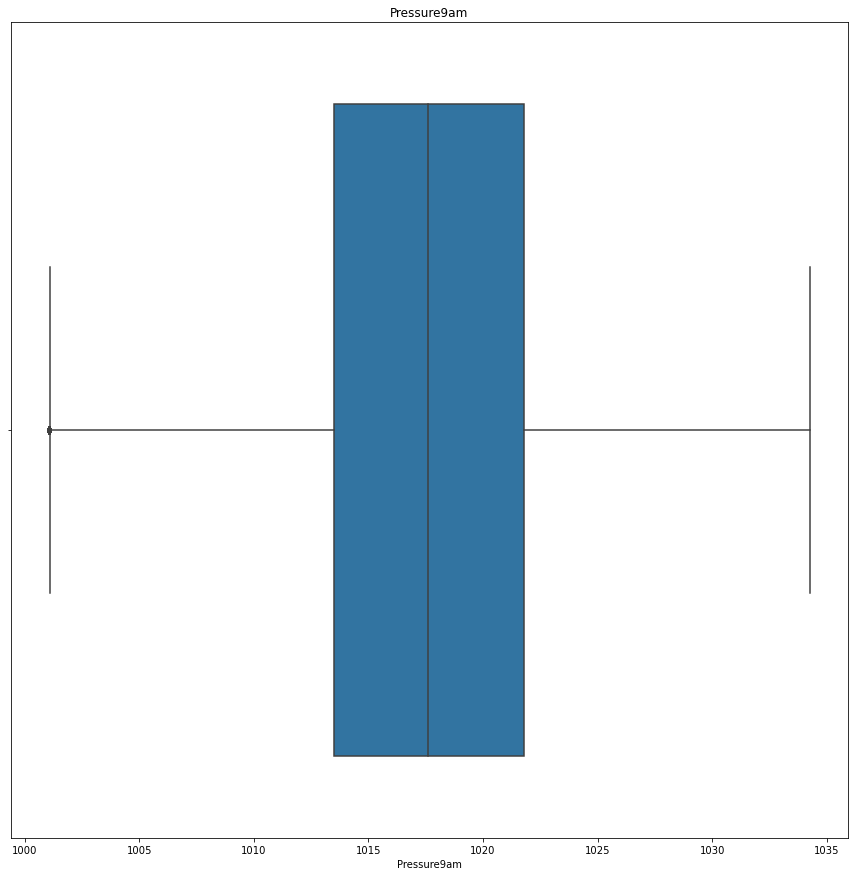

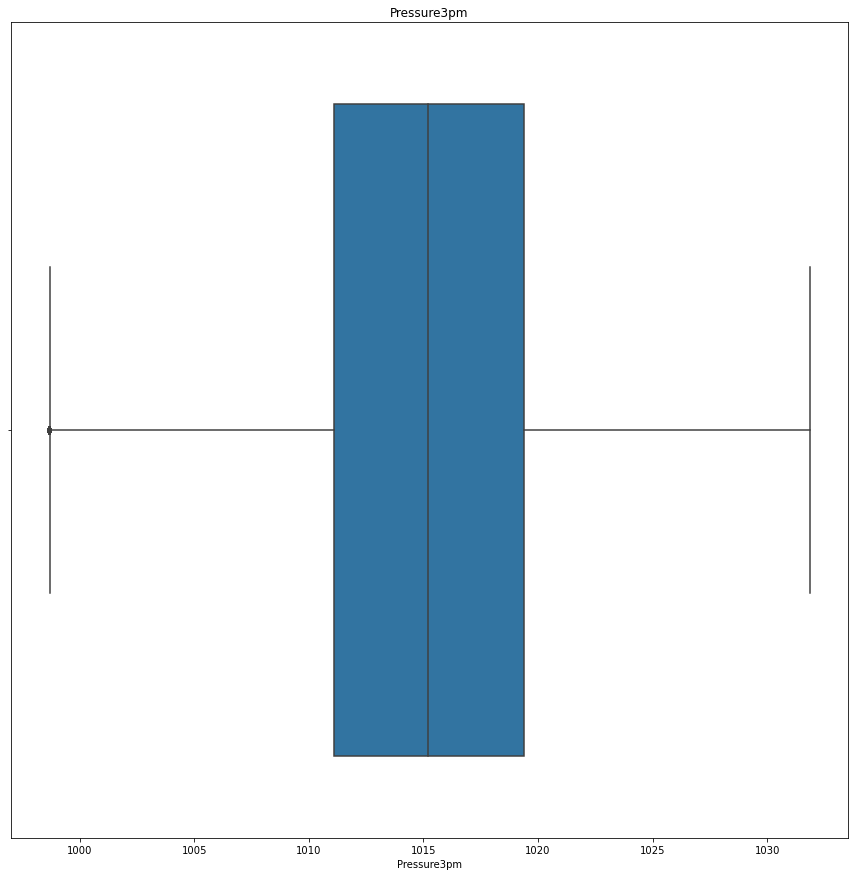

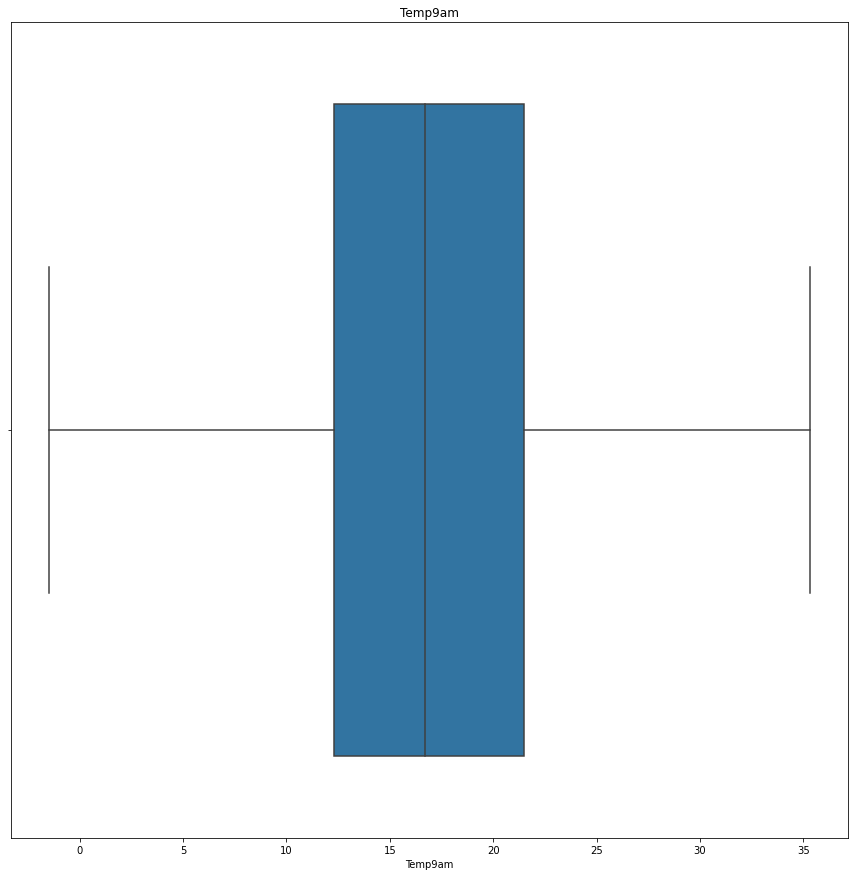

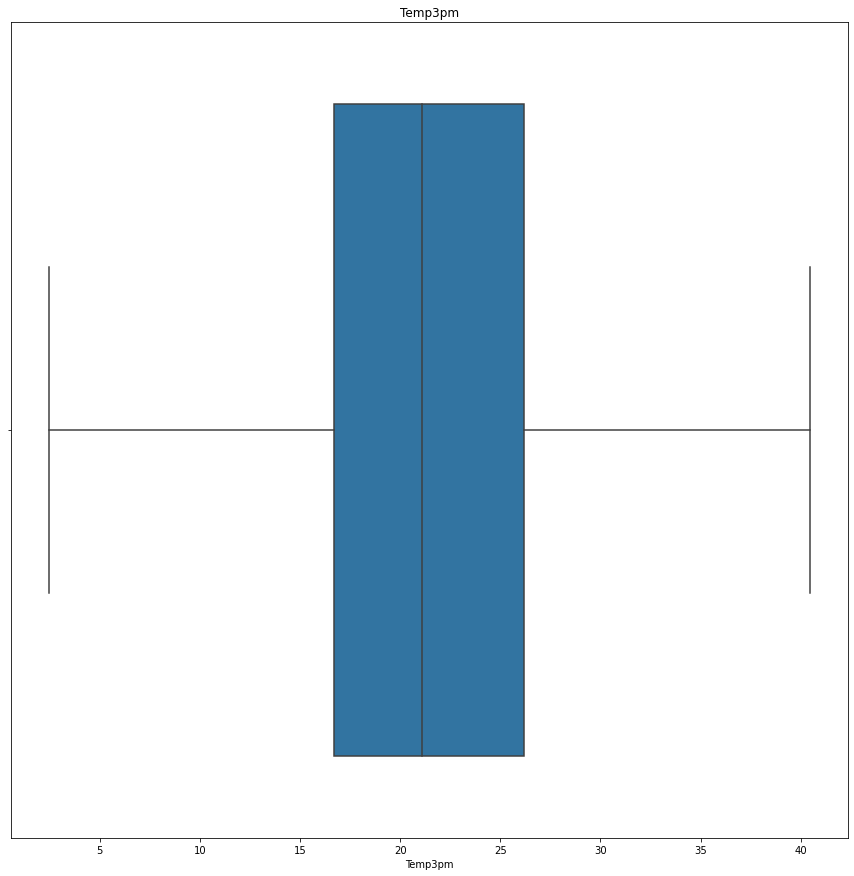

<Figure size 1080x1080 with 0 Axes>

In [176]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [177]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


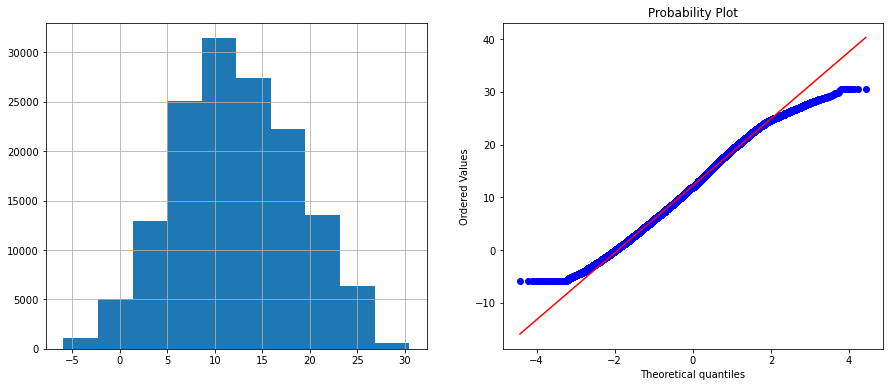

MaxTemp


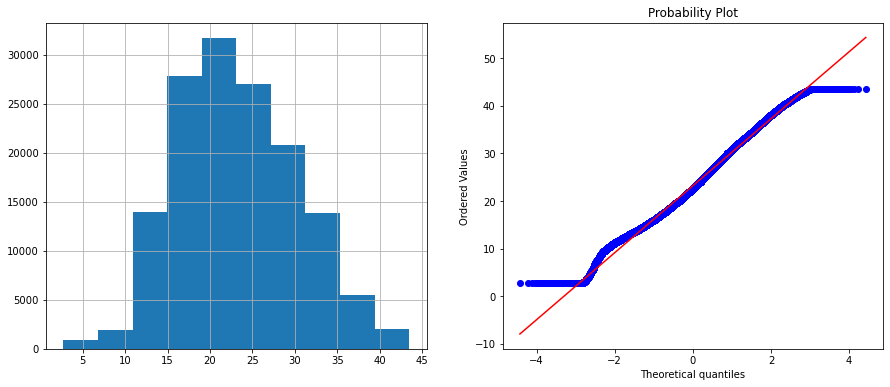

Rainfall


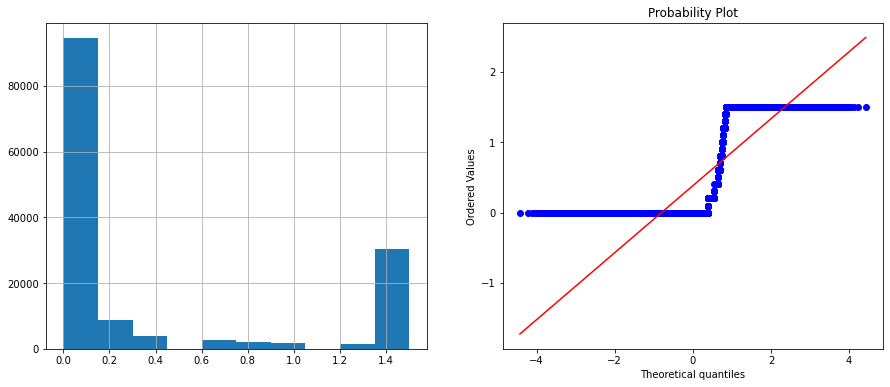

Evaporation


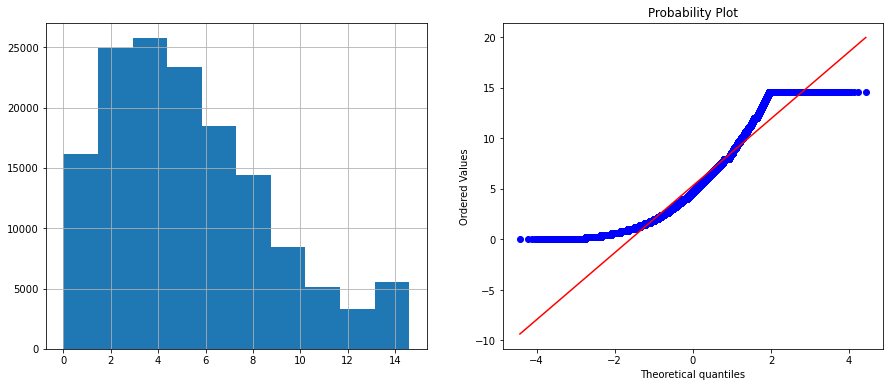

Sunshine


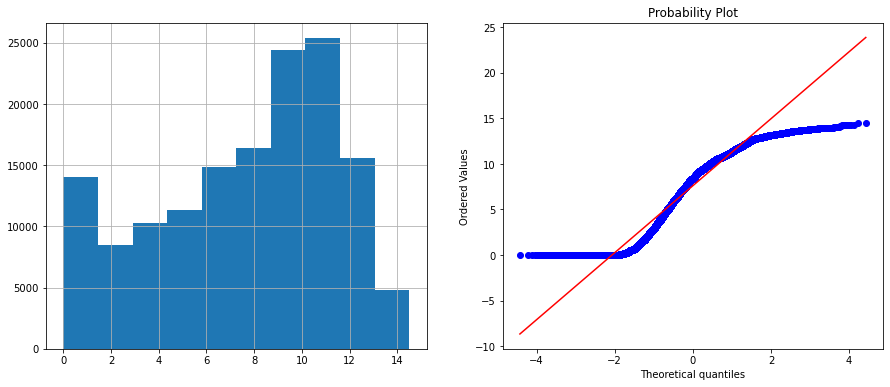

WindGustSpeed


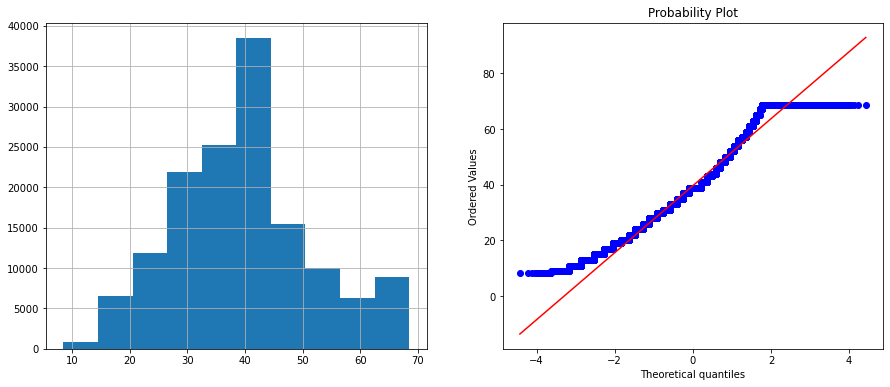

WindSpeed9am


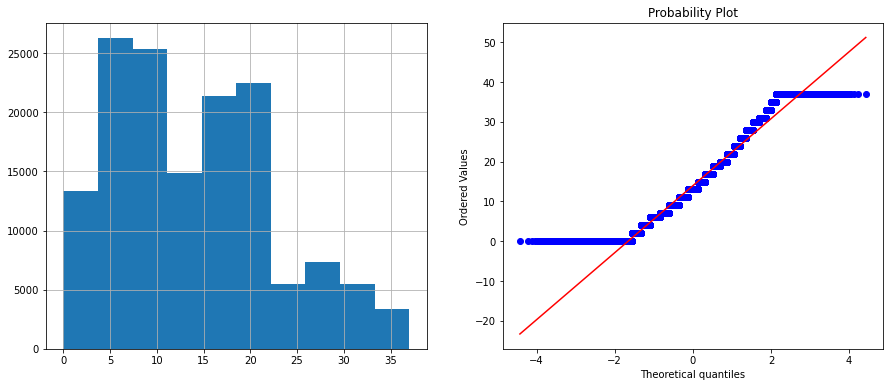

WindSpeed3pm


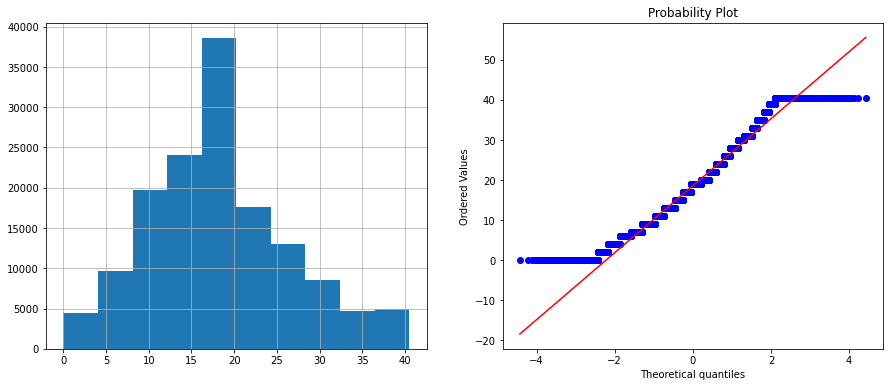

Humidity9am


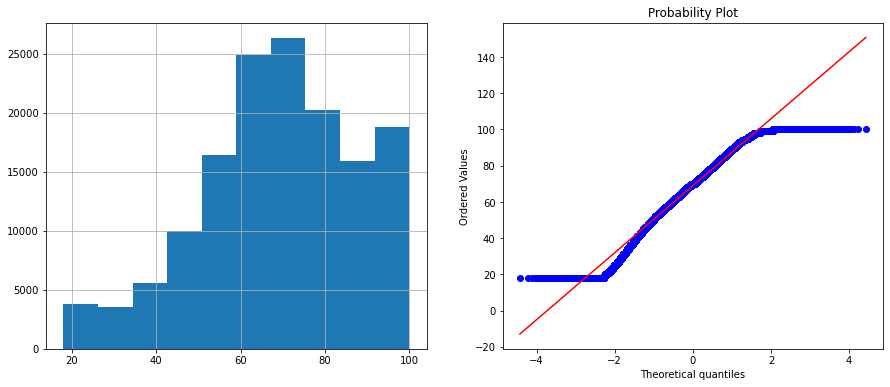

Humidity3pm


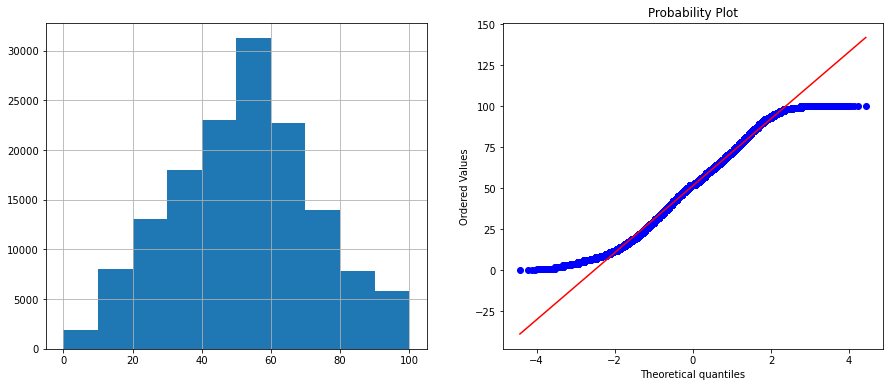

Pressure9am


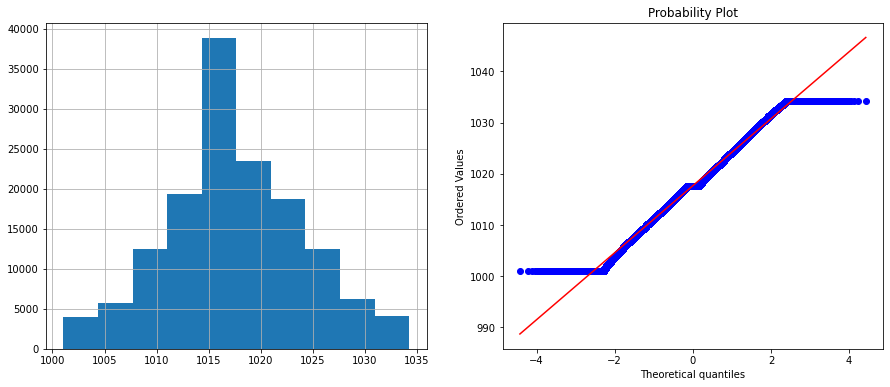

Pressure3pm


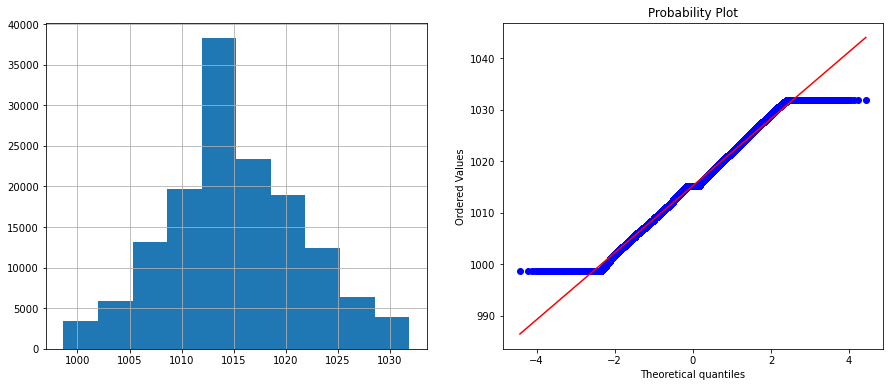

Temp9am


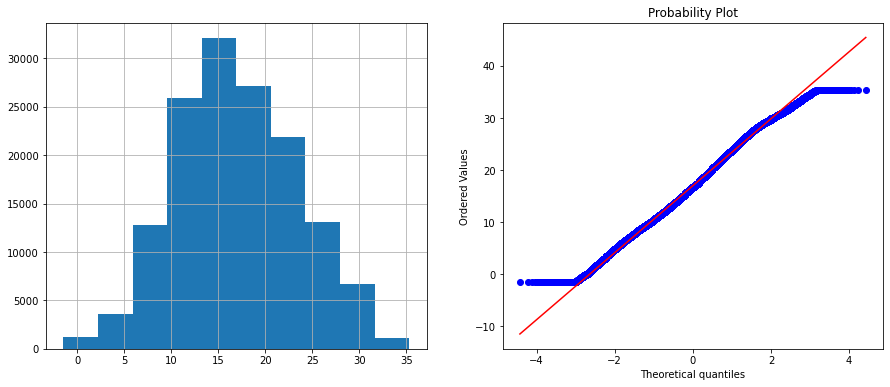

Temp3pm


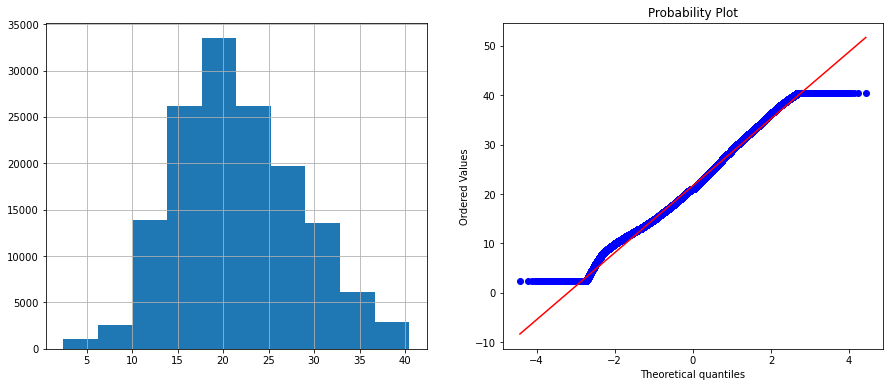

In [178]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [179]:
df.to_csv("preprocessed_1.csv", index=False)

In [180]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
Y = df["RainTomorrow"]

In [181]:
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [184]:
X_train.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Date_month', 'Date_day'],
      dtype='object')

In [185]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [186]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.050311
0:	total: 67ms	remaining: 2m 14s
1:	total: 136ms	remaining: 2m 15s
2:	total: 205ms	remaining: 2m 16s
3:	total: 270ms	remaining: 2m 14s
4:	total: 336ms	remaining: 2m 14s
5:	total: 400ms	remaining: 2m 12s
6:	total: 467ms	remaining: 2m 13s
7:	total: 535ms	remaining: 2m 13s
8:	total: 601ms	remaining: 2m 12s
9:	total: 672ms	remaining: 2m 13s
10:	total: 736ms	remaining: 2m 13s
11:	total: 799ms	remaining: 2m 12s
12:	total: 870ms	remaining: 2m 12s
13:	total: 935ms	remaining: 2m 12s
14:	total: 1s	remaining: 2m 12s
15:	total: 1.06s	remaining: 2m 11s
16:	total: 1.14s	remaining: 2m 13s
17:	total: 1.22s	remaining: 2m 14s
18:	total: 1.29s	remaining: 2m 14s
19:	total: 1.36s	remaining: 2m 14s
20:	total: 1.44s	remaining: 2m 15s
21:	total: 1.51s	remaining: 2m 16s
22:	total: 1.59s	remaining: 2m 16s
23:	total: 1.66s	remaining: 2m 16s
24:	total: 1.74s	remaining: 2m 17s
25:	total: 1.81s	remaining: 2m 17s
26:	total: 1.87s	remaining: 2m 16s
27:	total: 1.95s	remaining: 2m 17s
28:	

234:	total: 14.9s	remaining: 1m 51s
235:	total: 15s	remaining: 1m 51s
236:	total: 15s	remaining: 1m 51s
237:	total: 15.1s	remaining: 1m 51s
238:	total: 15.1s	remaining: 1m 51s
239:	total: 15.2s	remaining: 1m 51s
240:	total: 15.3s	remaining: 1m 51s
241:	total: 15.3s	remaining: 1m 51s
242:	total: 15.4s	remaining: 1m 51s
243:	total: 15.4s	remaining: 1m 51s
244:	total: 15.5s	remaining: 1m 51s
245:	total: 15.6s	remaining: 1m 51s
246:	total: 15.7s	remaining: 1m 51s
247:	total: 15.7s	remaining: 1m 51s
248:	total: 15.8s	remaining: 1m 51s
249:	total: 15.9s	remaining: 1m 50s
250:	total: 15.9s	remaining: 1m 50s
251:	total: 16s	remaining: 1m 50s
252:	total: 16.1s	remaining: 1m 50s
253:	total: 16.1s	remaining: 1m 50s
254:	total: 16.2s	remaining: 1m 50s
255:	total: 16.2s	remaining: 1m 50s
256:	total: 16.3s	remaining: 1m 50s
257:	total: 16.4s	remaining: 1m 50s
258:	total: 16.4s	remaining: 1m 50s
259:	total: 16.5s	remaining: 1m 50s
260:	total: 16.6s	remaining: 1m 50s
261:	total: 16.6s	remaining: 1m 50

465:	total: 28.4s	remaining: 1m 33s
466:	total: 28.5s	remaining: 1m 33s
467:	total: 28.5s	remaining: 1m 33s
468:	total: 28.6s	remaining: 1m 33s
469:	total: 28.6s	remaining: 1m 33s
470:	total: 28.7s	remaining: 1m 33s
471:	total: 28.7s	remaining: 1m 32s
472:	total: 28.8s	remaining: 1m 32s
473:	total: 28.8s	remaining: 1m 32s
474:	total: 28.9s	remaining: 1m 32s
475:	total: 28.9s	remaining: 1m 32s
476:	total: 29s	remaining: 1m 32s
477:	total: 29s	remaining: 1m 32s
478:	total: 29.1s	remaining: 1m 32s
479:	total: 29.1s	remaining: 1m 32s
480:	total: 29.2s	remaining: 1m 32s
481:	total: 29.2s	remaining: 1m 32s
482:	total: 29.3s	remaining: 1m 31s
483:	total: 29.3s	remaining: 1m 31s
484:	total: 29.4s	remaining: 1m 31s
485:	total: 29.5s	remaining: 1m 31s
486:	total: 29.5s	remaining: 1m 31s
487:	total: 29.6s	remaining: 1m 31s
488:	total: 29.6s	remaining: 1m 31s
489:	total: 29.7s	remaining: 1m 31s
490:	total: 29.7s	remaining: 1m 31s
491:	total: 29.8s	remaining: 1m 31s
492:	total: 29.8s	remaining: 1m 

695:	total: 41.1s	remaining: 1m 17s
696:	total: 41.2s	remaining: 1m 16s
697:	total: 41.2s	remaining: 1m 16s
698:	total: 41.3s	remaining: 1m 16s
699:	total: 41.3s	remaining: 1m 16s
700:	total: 41.4s	remaining: 1m 16s
701:	total: 41.5s	remaining: 1m 16s
702:	total: 41.5s	remaining: 1m 16s
703:	total: 41.6s	remaining: 1m 16s
704:	total: 41.6s	remaining: 1m 16s
705:	total: 41.7s	remaining: 1m 16s
706:	total: 41.8s	remaining: 1m 16s
707:	total: 41.8s	remaining: 1m 16s
708:	total: 41.9s	remaining: 1m 16s
709:	total: 41.9s	remaining: 1m 16s
710:	total: 42s	remaining: 1m 16s
711:	total: 42s	remaining: 1m 16s
712:	total: 42.1s	remaining: 1m 15s
713:	total: 42.1s	remaining: 1m 15s
714:	total: 42.2s	remaining: 1m 15s
715:	total: 42.2s	remaining: 1m 15s
716:	total: 42.3s	remaining: 1m 15s
717:	total: 42.3s	remaining: 1m 15s
718:	total: 42.4s	remaining: 1m 15s
719:	total: 42.4s	remaining: 1m 15s
720:	total: 42.5s	remaining: 1m 15s
721:	total: 42.5s	remaining: 1m 15s
722:	total: 42.6s	remaining: 1m 

931:	total: 55.4s	remaining: 1m 3s
932:	total: 55.5s	remaining: 1m 3s
933:	total: 55.5s	remaining: 1m 3s
934:	total: 55.6s	remaining: 1m 3s
935:	total: 55.6s	remaining: 1m 3s
936:	total: 55.7s	remaining: 1m 3s
937:	total: 55.7s	remaining: 1m 3s
938:	total: 55.8s	remaining: 1m 3s
939:	total: 55.9s	remaining: 1m 2s
940:	total: 55.9s	remaining: 1m 2s
941:	total: 56s	remaining: 1m 2s
942:	total: 56.1s	remaining: 1m 2s
943:	total: 56.1s	remaining: 1m 2s
944:	total: 56.2s	remaining: 1m 2s
945:	total: 56.3s	remaining: 1m 2s
946:	total: 56.3s	remaining: 1m 2s
947:	total: 56.4s	remaining: 1m 2s
948:	total: 56.4s	remaining: 1m 2s
949:	total: 56.5s	remaining: 1m 2s
950:	total: 56.6s	remaining: 1m 2s
951:	total: 56.6s	remaining: 1m 2s
952:	total: 56.7s	remaining: 1m 2s
953:	total: 56.7s	remaining: 1m 2s
954:	total: 56.8s	remaining: 1m 2s
955:	total: 56.8s	remaining: 1m 2s
956:	total: 56.9s	remaining: 1m 2s
957:	total: 56.9s	remaining: 1m 1s
958:	total: 57s	remaining: 1m 1s
959:	total: 57s	remainin

1169:	total: 1m 9s	remaining: 49s
1170:	total: 1m 9s	remaining: 49s
1171:	total: 1m 9s	remaining: 48.9s
1172:	total: 1m 9s	remaining: 48.9s
1173:	total: 1m 9s	remaining: 48.8s
1174:	total: 1m 9s	remaining: 48.7s
1175:	total: 1m 9s	remaining: 48.7s
1176:	total: 1m 9s	remaining: 48.6s
1177:	total: 1m 9s	remaining: 48.5s
1178:	total: 1m 9s	remaining: 48.5s
1179:	total: 1m 9s	remaining: 48.4s
1180:	total: 1m 9s	remaining: 48.4s
1181:	total: 1m 9s	remaining: 48.3s
1182:	total: 1m 9s	remaining: 48.2s
1183:	total: 1m 9s	remaining: 48.1s
1184:	total: 1m 9s	remaining: 48.1s
1185:	total: 1m 9s	remaining: 48s
1186:	total: 1m 10s	remaining: 48s
1187:	total: 1m 10s	remaining: 47.9s
1188:	total: 1m 10s	remaining: 47.8s
1189:	total: 1m 10s	remaining: 47.8s
1190:	total: 1m 10s	remaining: 47.7s
1191:	total: 1m 10s	remaining: 47.7s
1192:	total: 1m 10s	remaining: 47.6s
1193:	total: 1m 10s	remaining: 47.5s
1194:	total: 1m 10s	remaining: 47.5s
1195:	total: 1m 10s	remaining: 47.4s
1196:	total: 1m 10s	remain

1395:	total: 1m 21s	remaining: 35.2s
1396:	total: 1m 21s	remaining: 35.1s
1397:	total: 1m 21s	remaining: 35.1s
1398:	total: 1m 21s	remaining: 35s
1399:	total: 1m 21s	remaining: 35s
1400:	total: 1m 21s	remaining: 34.9s
1401:	total: 1m 21s	remaining: 34.8s
1402:	total: 1m 21s	remaining: 34.8s
1403:	total: 1m 21s	remaining: 34.7s
1404:	total: 1m 21s	remaining: 34.6s
1405:	total: 1m 21s	remaining: 34.6s
1406:	total: 1m 21s	remaining: 34.5s
1407:	total: 1m 21s	remaining: 34.5s
1408:	total: 1m 22s	remaining: 34.4s
1409:	total: 1m 22s	remaining: 34.3s
1410:	total: 1m 22s	remaining: 34.3s
1411:	total: 1m 22s	remaining: 34.2s
1412:	total: 1m 22s	remaining: 34.1s
1413:	total: 1m 22s	remaining: 34.1s
1414:	total: 1m 22s	remaining: 34s
1415:	total: 1m 22s	remaining: 34s
1416:	total: 1m 22s	remaining: 33.9s
1417:	total: 1m 22s	remaining: 33.8s
1418:	total: 1m 22s	remaining: 33.8s
1419:	total: 1m 22s	remaining: 33.7s
1420:	total: 1m 22s	remaining: 33.7s
1421:	total: 1m 22s	remaining: 33.6s
1422:	tot

1618:	total: 1m 33s	remaining: 21.9s
1619:	total: 1m 33s	remaining: 21.9s
1620:	total: 1m 33s	remaining: 21.8s
1621:	total: 1m 33s	remaining: 21.8s
1622:	total: 1m 33s	remaining: 21.7s
1623:	total: 1m 33s	remaining: 21.7s
1624:	total: 1m 33s	remaining: 21.6s
1625:	total: 1m 33s	remaining: 21.5s
1626:	total: 1m 33s	remaining: 21.5s
1627:	total: 1m 33s	remaining: 21.4s
1628:	total: 1m 33s	remaining: 21.4s
1629:	total: 1m 33s	remaining: 21.3s
1630:	total: 1m 33s	remaining: 21.3s
1631:	total: 1m 34s	remaining: 21.2s
1632:	total: 1m 34s	remaining: 21.1s
1633:	total: 1m 34s	remaining: 21.1s
1634:	total: 1m 34s	remaining: 21s
1635:	total: 1m 34s	remaining: 21s
1636:	total: 1m 34s	remaining: 20.9s
1637:	total: 1m 34s	remaining: 20.9s
1638:	total: 1m 34s	remaining: 20.8s
1639:	total: 1m 34s	remaining: 20.8s
1640:	total: 1m 34s	remaining: 20.7s
1641:	total: 1m 34s	remaining: 20.6s
1642:	total: 1m 34s	remaining: 20.6s
1643:	total: 1m 34s	remaining: 20.5s
1644:	total: 1m 34s	remaining: 20.5s
1645:

1842:	total: 1m 46s	remaining: 9.03s
1843:	total: 1m 46s	remaining: 8.97s
1844:	total: 1m 46s	remaining: 8.92s
1845:	total: 1m 46s	remaining: 8.86s
1846:	total: 1m 46s	remaining: 8.8s
1847:	total: 1m 46s	remaining: 8.75s
1848:	total: 1m 46s	remaining: 8.69s
1849:	total: 1m 46s	remaining: 8.63s
1850:	total: 1m 46s	remaining: 8.58s
1851:	total: 1m 46s	remaining: 8.52s
1852:	total: 1m 46s	remaining: 8.46s
1853:	total: 1m 46s	remaining: 8.4s
1854:	total: 1m 46s	remaining: 8.35s
1855:	total: 1m 46s	remaining: 8.29s
1856:	total: 1m 46s	remaining: 8.23s
1857:	total: 1m 46s	remaining: 8.18s
1858:	total: 1m 47s	remaining: 8.12s
1859:	total: 1m 47s	remaining: 8.06s
1860:	total: 1m 47s	remaining: 8.01s
1861:	total: 1m 47s	remaining: 7.95s
1862:	total: 1m 47s	remaining: 7.89s
1863:	total: 1m 47s	remaining: 7.83s
1864:	total: 1m 47s	remaining: 7.78s
1865:	total: 1m 47s	remaining: 7.72s
1866:	total: 1m 47s	remaining: 7.66s
1867:	total: 1m 47s	remaining: 7.61s
1868:	total: 1m 47s	remaining: 7.55s
186

In [187]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[20799  1918]
 [ 2942  3433]]
0.8329437646088271
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22717
           1       0.64      0.54      0.59      6375

    accuracy                           0.83     29092
   macro avg       0.76      0.73      0.74     29092
weighted avg       0.82      0.83      0.83     29092



E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7270398207440744

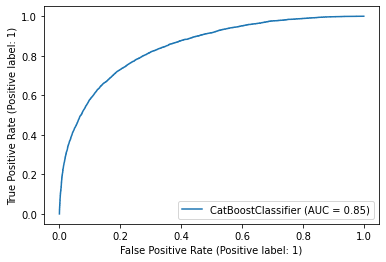

In [188]:
metrics.plot_roc_curve(cat, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred, average=None) 

In [189]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [ ]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

In [ ]:
metrics.plot_roc_curve(rf, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None) 

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

In [ ]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

In [ ]:
metrics.plot_roc_curve(logreg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None) 

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

In [ ]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

In [ ]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

In [ ]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

In [ ]:
metrics.plot_roc_curve(knn, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred4, average=None) 

In [190]:
xgb = XGBClassifier()
model=xgb.fit(X_train_res, y_train_res)

In [191]:
y_pred6 = model.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[20152  2565]
 [ 2625  3750]]
0.8216004399835006
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     22717
           1       0.59      0.59      0.59      6375

    accuracy                           0.82     29092
   macro avg       0.74      0.74      0.74     29092
weighted avg       0.82      0.82      0.82     29092



E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7376621291647355

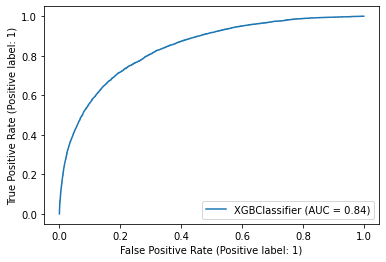

In [192]:
metrics.plot_roc_curve(xgb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred6, average=None) 

In [193]:
import pickle
pickle.dump(model,open("xgb.pkl","wb"))